# imports

In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packag

In [4]:
e = exp.load('iter_exps10_3iters', experiment_location='experiments', datadir='Mdata')
e5 = exp.load('iter_exps10_5iters', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.10140363

In [5]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

# readout weights

(68, 111)


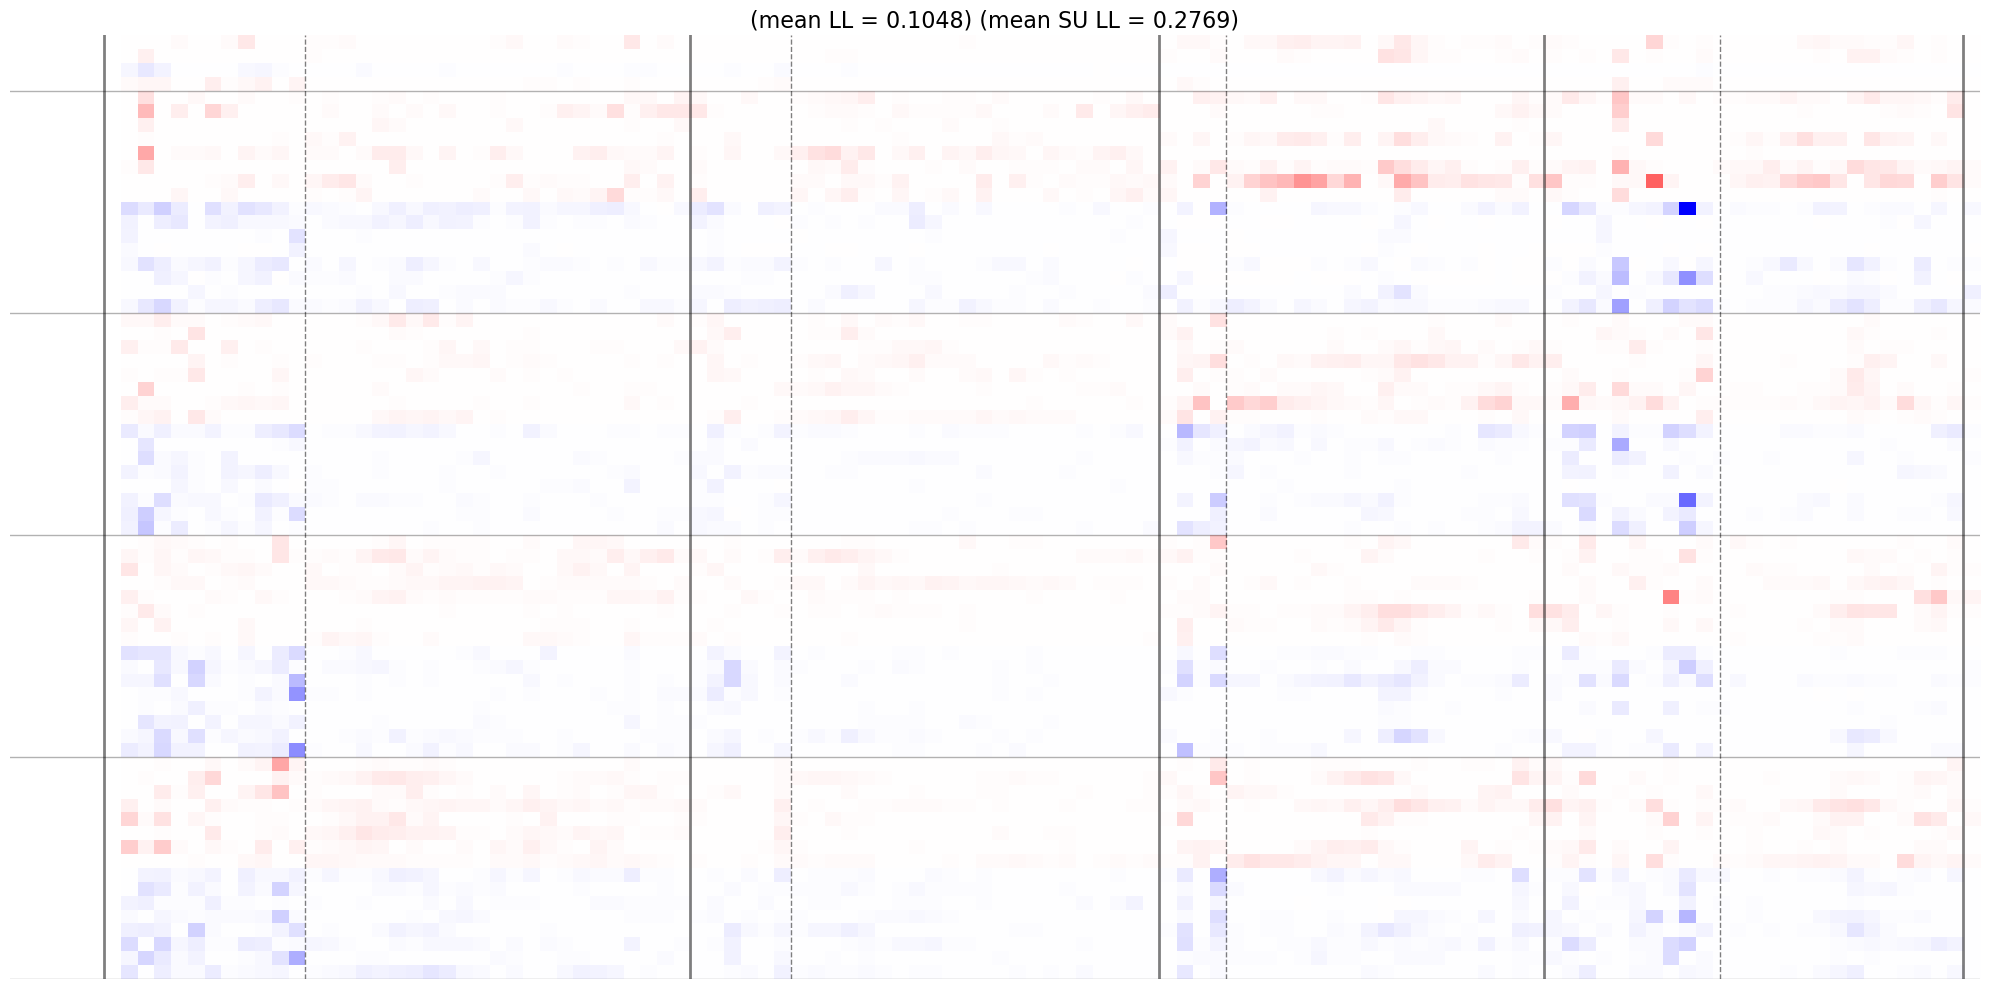

In [14]:
readout_weights = np.sum(e3.trials[0].model.networks[-1].layers[-1].weights[:,:,:], axis=1)
print(readout_weights.shape)
# make inhibitory weights negative (every 12 weights need to be flipped)
readout_weights[2,:] = -readout_weights[2,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]

# get the mean LLs for just the SUs in k
mean_SU_LLs = np.mean(e.trials[0].LLs[dataset.SUs])

# get the mean LLs for k
mean_LLs = np.mean(e.trials[0].LLs)

fig = plt.figure(figsize=(20,10))
plot.imagesc(readout_weights, cmap='bwr', colrow=False, origin='upper')
plt.title('(mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
plt.axis('off')

# put a vertical line between each experiment
for expt_boundary in expt_boundaries:
    plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)

# put a vertical line between the SUs and the MUs
# get the indices of the SUs where the experiment boundaries are
SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

for SU_boundary in SU_boundaries:
    plt.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
# plot the last SU boundary
plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

layer_boundaries = [0, 4, 20, 36, 52, 68, 84]

# put a horizontal line between each layer
for layer_boundary in layer_boundaries[1:-1]:
    plt.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# avg connection depth

0 2
2 4
4 12
12 20
20 28
28 36
36 44
44 52
52 60
60 68


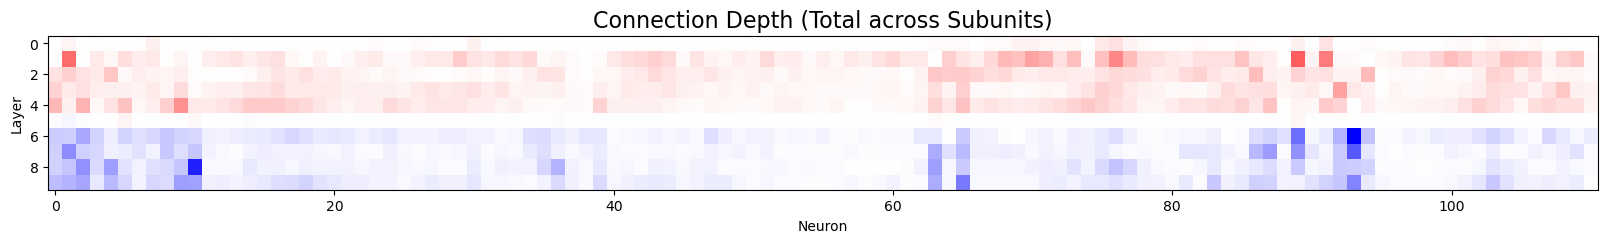

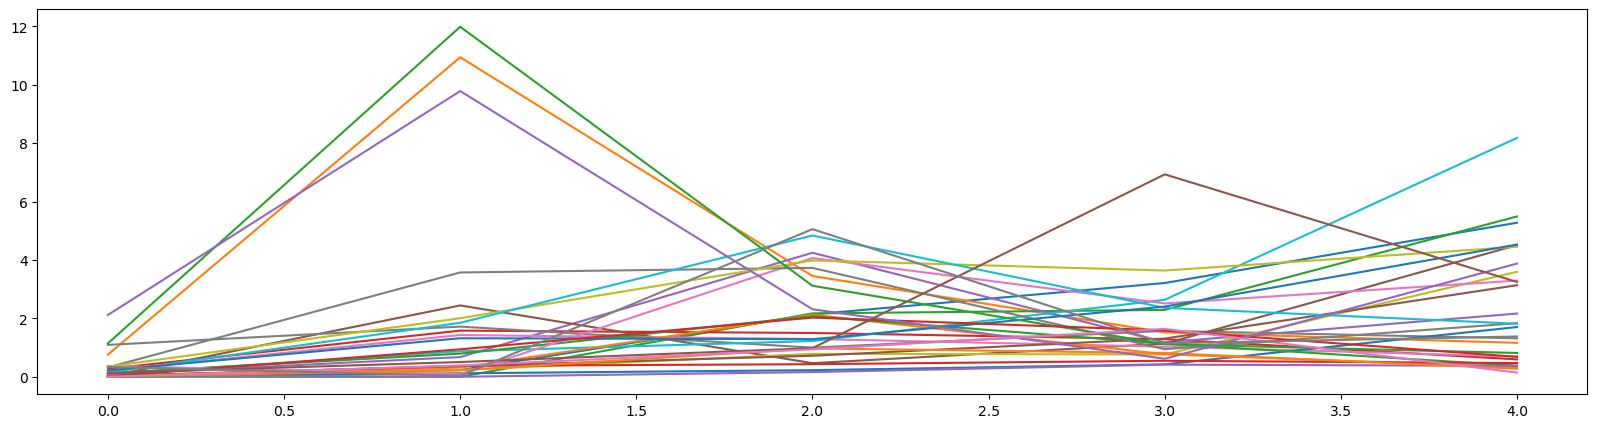

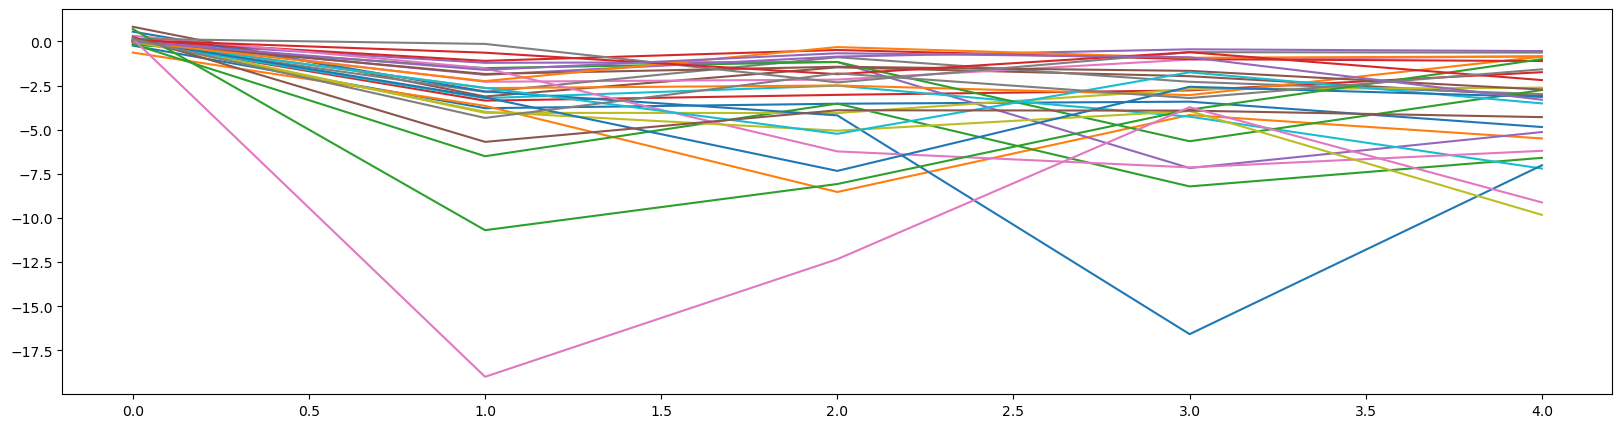

In [44]:
excs = []
inhs = []

layer_boundaries = [0, 4, 20, 36, 52, 68]
for i in range(1, len(layer_boundaries)):
    layer_size = layer_boundaries[i] - layer_boundaries[i-1]
    print(layer_boundaries[i-1], layer_boundaries[i-1]+layer_size//2)
    print(layer_boundaries[i-1]+layer_size//2, layer_boundaries[i])
    exc = np.sum(readout_weights[layer_boundaries[i-1]:layer_boundaries[i-1]+layer_size//2, :], axis=0)
    inh = np.sum(readout_weights[layer_boundaries[i-1]+layer_size//2:layer_boundaries[i], :], axis=0)
    excs.append(exc)
    inhs.append(inh)

fig = plt.figure(figsize=(20,2))
grid = plt.GridSpec(2, 5, wspace=0.2, hspace=0.2)
stacked = np.zeros((10, 111))
for i in range(0, 5):
    stacked[i,:] = excs[i]
for i,j in enumerate(range(5, 10)):
    stacked[j,:] = inhs[i-5]
plot.imagesc(stacked, cmap='bwr', colrow=False, origin='upper')
plt.xlabel('Neuron')
plt.ylabel('Layer')
plt.title('Connection Depth (Total across Subunits)', fontsize=16)
plt.show()

fig = plt.figure(figsize=(20,5))
plt.plot(np.array(excs)[:, dataset.SUs])
plt.show()
fig = plt.figure(figsize=(20,5))
plt.plot(np.array(inhs)[:, dataset.SUs])
plt.show()

# neuron readout weights

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


Readout weights shape (68, 36, 111)


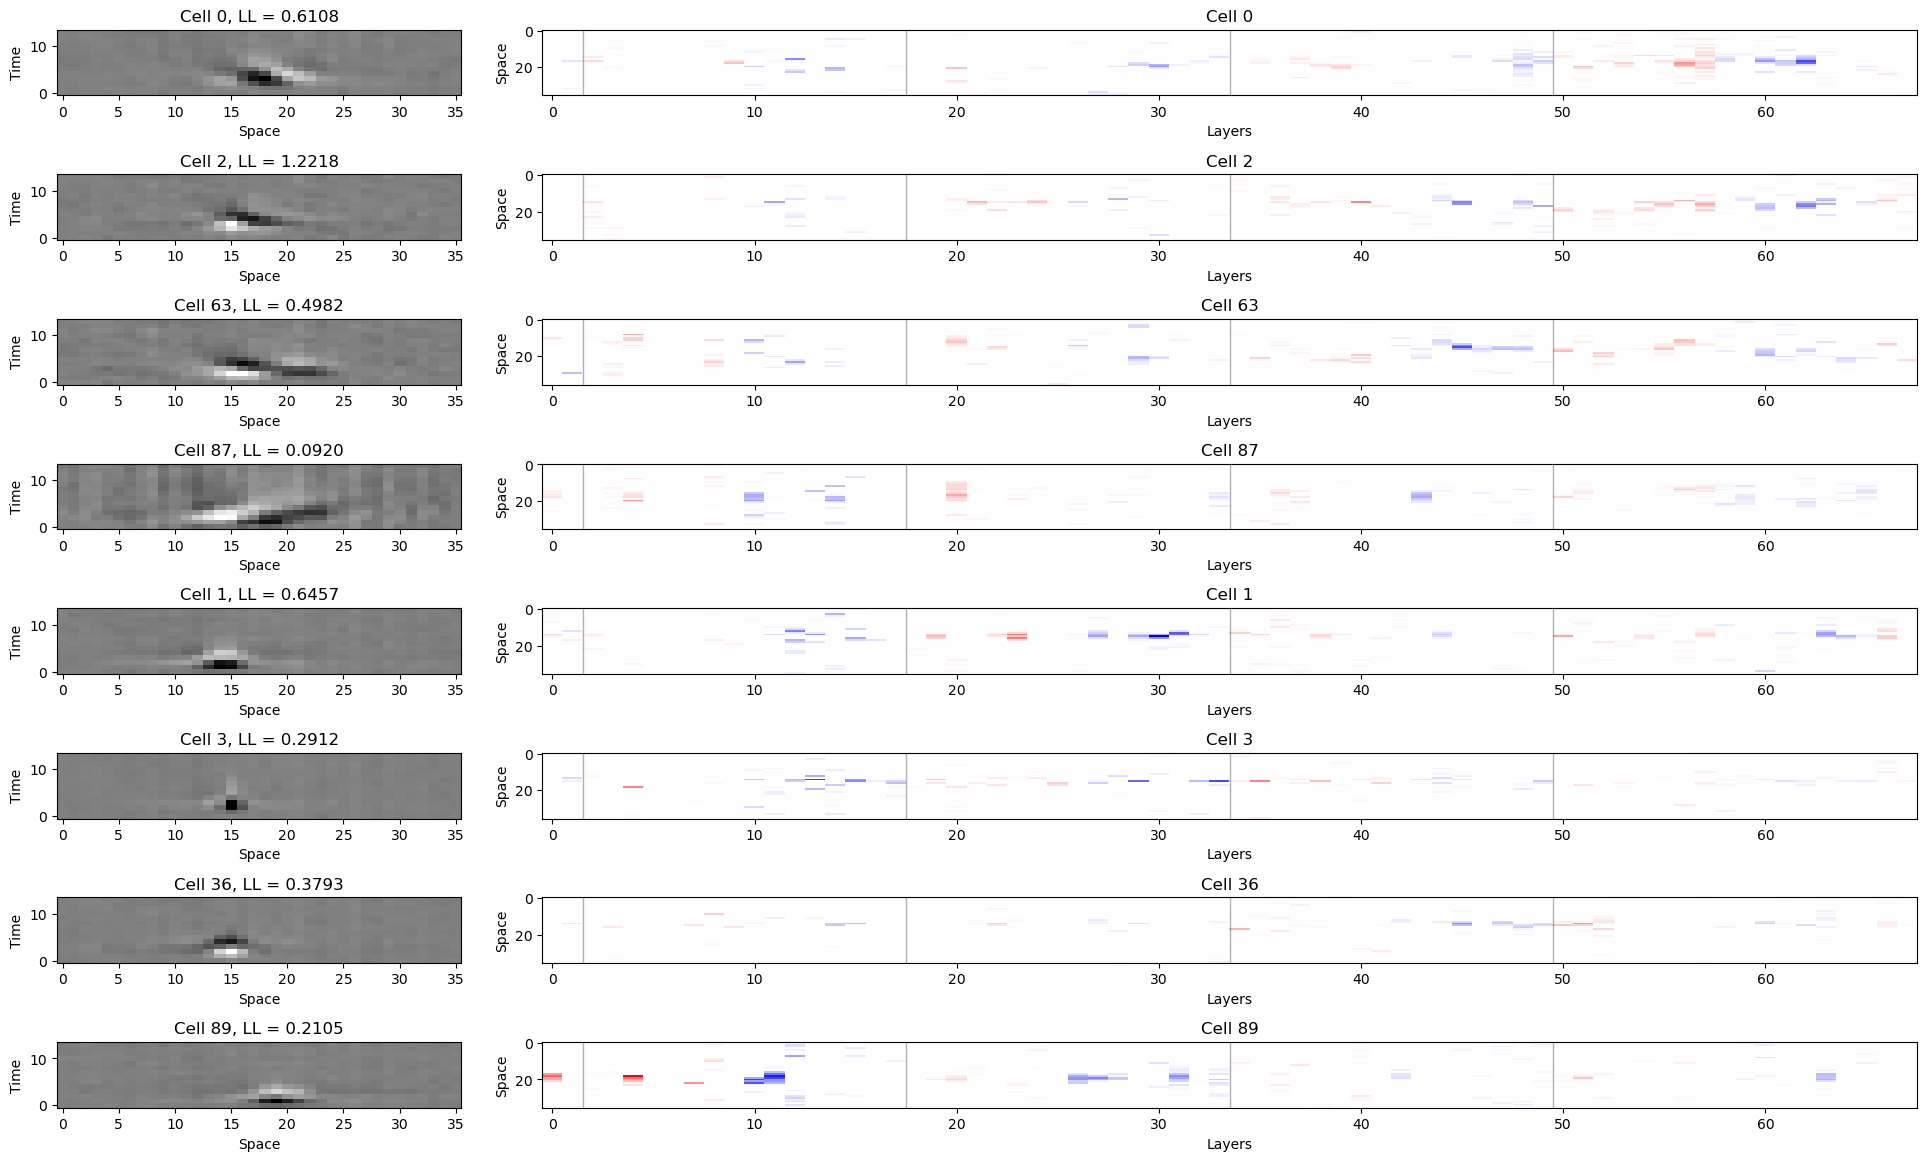

In [16]:
dirsel_neurons = [0, 2, 63, 87] + [1, 3, 36, 89]

preds = predict.calc_preds(dataset, e.trials[0].model, end=50000, batch_size=5000)
stas, pred = predict.calc_STAs(dataset, preds, end=50000)

# get the weights
readout_weights = e.trials[0].model.networks[1].layers[0].weights
print('Readout weights shape', readout_weights.shape)
readout_weights[1,:,:] = -readout_weights[1,:,:]
for i in range(10,readout_weights.shape[0],16):
    readout_weights[i:i+8,:,:] = -readout_weights[i:i+8,:,:]

pred_max = np.max(pred[:,:,dirsel_neurons])
pred_min = -pred_max

readout_max = np.max(readout_weights[:,:,dirsel_neurons])
readout_min = -readout_max

fig = plt.figure(figsize=(24,14))
rows,cols = len(dirsel_neurons),4
gridspec = fig.add_gridspec(rows,cols)
# put vertical space between the plots
gridspec.update(wspace=0.2, hspace=1.2)

cc = 0
for cc in range(len(dirsel_neurons)):
    ax = fig.add_subplot(gridspec[cc,0])
    plot.imagesc(pred[:,:,dirsel_neurons[cc]], cmap='gray', ax=ax)
    ax.set_title('Cell '+str(dirsel_neurons[cc])+', LL = %.4f' % e.trials[0].LLs[dirsel_neurons[cc]])
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')

    ax = fig.add_subplot(gridspec[cc,1:])
    ax.imshow(readout_weights[:,:,dirsel_neurons[cc]].T, cmap='bwr', aspect='auto', vmin=readout_min, vmax=readout_max, interpolation='none')
    ax.set_xlabel('Layers')
    ax.set_ylabel('Space')
    ax.set_title('Cell '+str(dirsel_neurons[cc]))

    # draw a vertical line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        # shift the line back by 0.5
        ax.axvline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

    cc += 1

# load outputs and Jacobians

In [6]:
import pickle

with open('results_iter_exps10_3iters_outputs.pkl', 'rb') as f:
    results_outputs = pickle.load(f)

In [7]:
class ResultsJacobian:
    def __init__(self, jacobian, times):
        self.jacobian = jacobian

with open('results_iter_exps10_3iters_jacobians.pkl', 'rb') as f:
    results_jacobians = pickle.load(f)

# PCA

In [6]:
import umap
import hdbscan
from sklearn.decomposition import PCA


cluster_labels = []
i = 0
with open('./results_iter_exps12_5iters_jacobians/0.pkl', 'rb') as f:
    results_jacobians = pickle.load(f)
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        if li < 2:
            for subunit in range(results_outputs.outputs[ni][li].shape[1]):
                imax = np.max(results_jacobians.jacobian.jacobians[0][0][:,subunit,17,0])
                imin = -imax
                print('ni', ni, 'li', li, 'subunit', subunit)
                jacobians = results_jacobians.jacobian.jacobians[0][0][:,subunit,17,0]
                # normalize the jacobians
                jacobians = (jacobians - imin) / (imax - imin)

                # cluster the jacobians
                #lowd_jacobians = umap.UMAP(random_state=42).fit_transform(jacobians)
                lowd_jacobians = PCA(n_components=10).fit_transform(jacobians)
                clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
                clusterer.fit(lowd_jacobians)
                print(clusterer.labels_)
                cluster_labels.append(clusterer.labels_)
                i += 1
                with open('./results_iter_exps12_5iters_jacobians/'+str(i)+'.pkl', 'rb') as f:
                    results_jacobians = pickle.load(f)
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                for subunit in range(results_outputs.outputs[ni][li].shape[2]):
                    imax = np.max(results_jacobians.jacobian.jacobians[0][0][:,iter,subunit,17,0])
                    imin = -imax
                    print('ni', ni, 'li', li, 'iter', iter, 'subunit', subunit)
                    jacobians = results_jacobians.jacobian.jacobians[0][0][:,iter,subunit,17,0]
                    # normalize the jacobians
                    jacobians = (jacobians - imin) / (imax - imin)

                    # cluster the jacobians
                    # lowd_jacobians = umap.UMAP(n_neighbors=30,
                    #                            min_dist=0.0,
                    #                            n_components=2,
                    #                            random_state=42,).fit_transform(jacobians)
                    lowd_jacobians = PCA(n_components=10).fit_transform(jacobians)
                    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
                    clusterer.fit(lowd_jacobians)
                    print(clusterer.labels_)
                    cluster_labels.append(clusterer.labels_)
                    i += 1
                    with open('./results_iter_exps12_5iters_jacobians/'+str(i)+'.pkl', 'rb') as f:
                        results_jacobians = pickle.load(f)

num_clusters = len(np.unique(np.vstack(cluster_labels)))

ni 0 li 0 subunit 0
[0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0
 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1
 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0]
ni 0 li 0 subunit 1
[0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0]
ni 0 li 0 subunit 2
[0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1]
ni 0 li 0 subunit 3
[1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0
 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
ni 0 li 1 subunit 0
[ 0  0  1  0  0  2  2  0  2  0 -1  0  0  1  0  0  2  0  0  2  0  2  0  1
  2  0  0  

In [7]:
cluster_labels_to_timepoints = []
for i in range(0, len(cluster_labels)):
    cluster_labels_to_timepoints.append({})
    for j in range(0, len(cluster_labels[i])):
        if cluster_labels[i][j] not in cluster_labels_to_timepoints[i]:
            cluster_labels_to_timepoints[i][cluster_labels[i][j]] = []
        cluster_labels_to_timepoints[i][cluster_labels[i][j]].append(j)

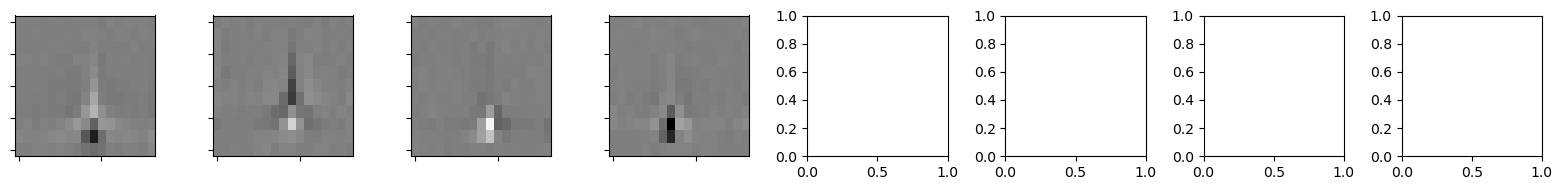

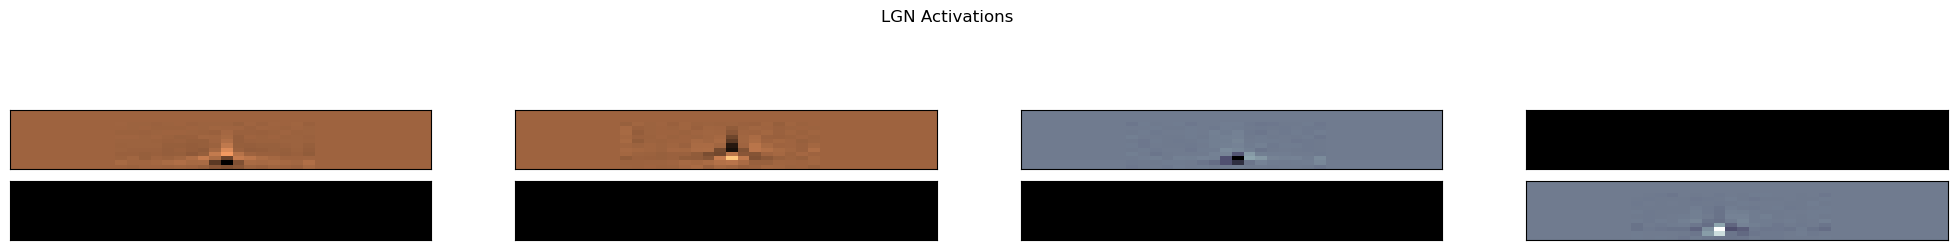

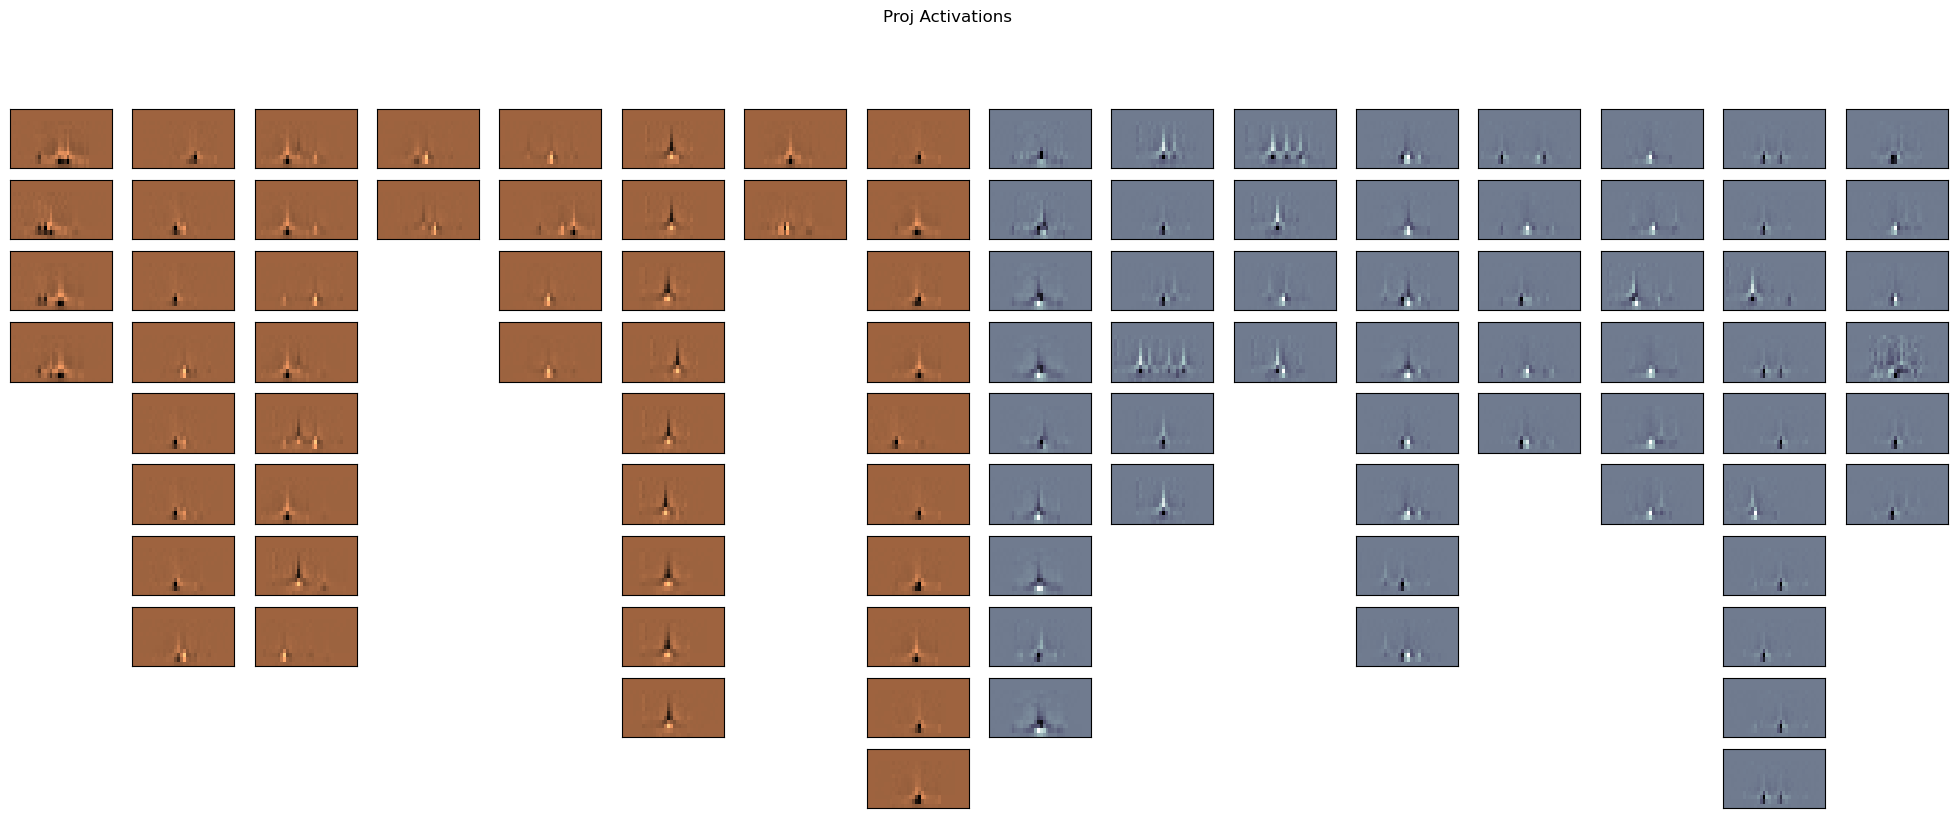

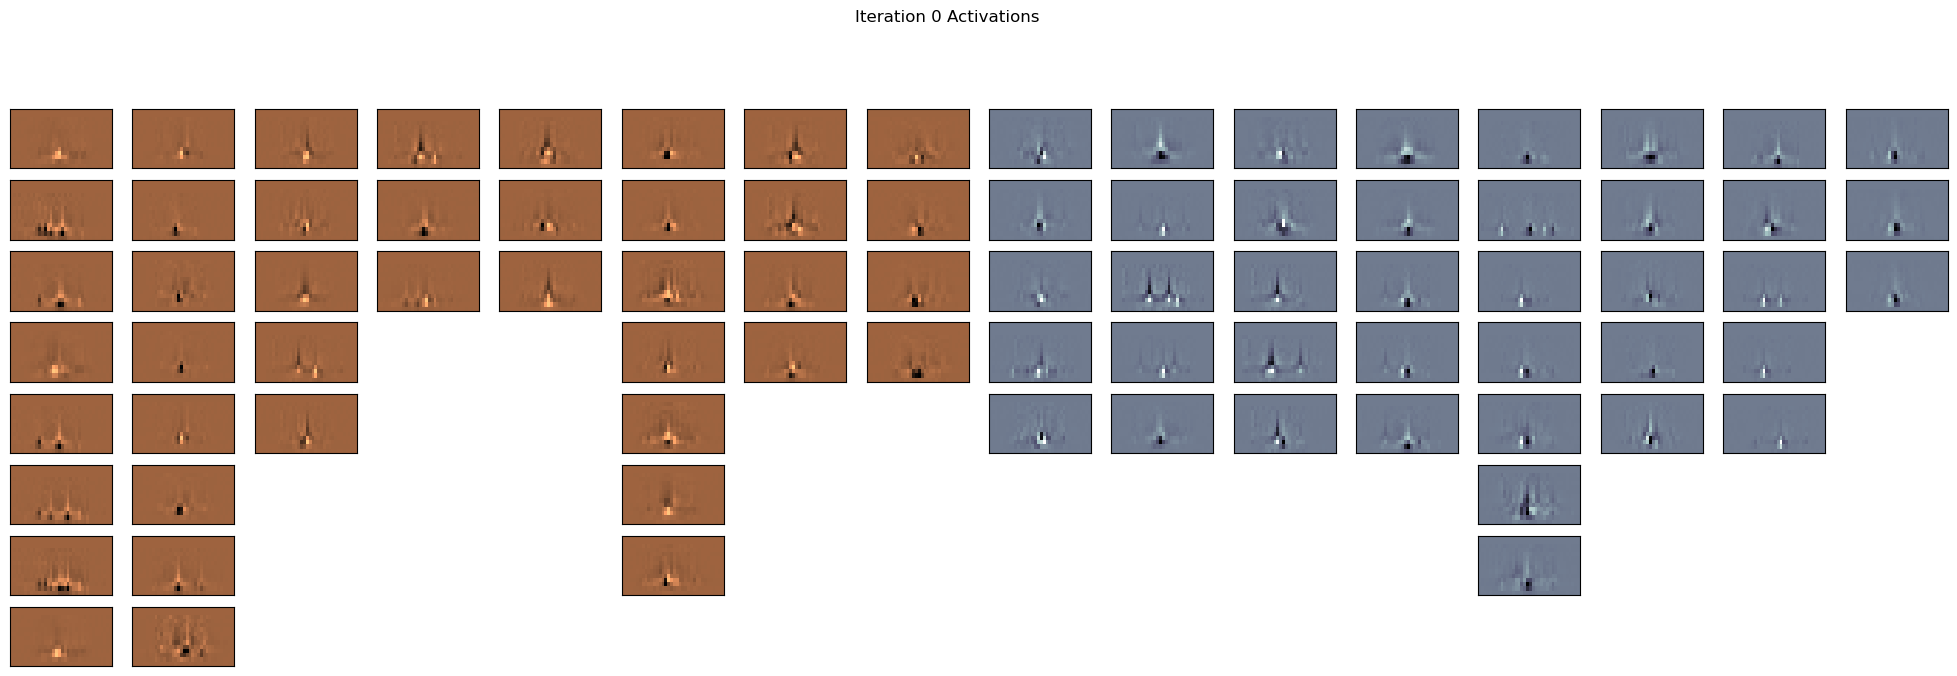

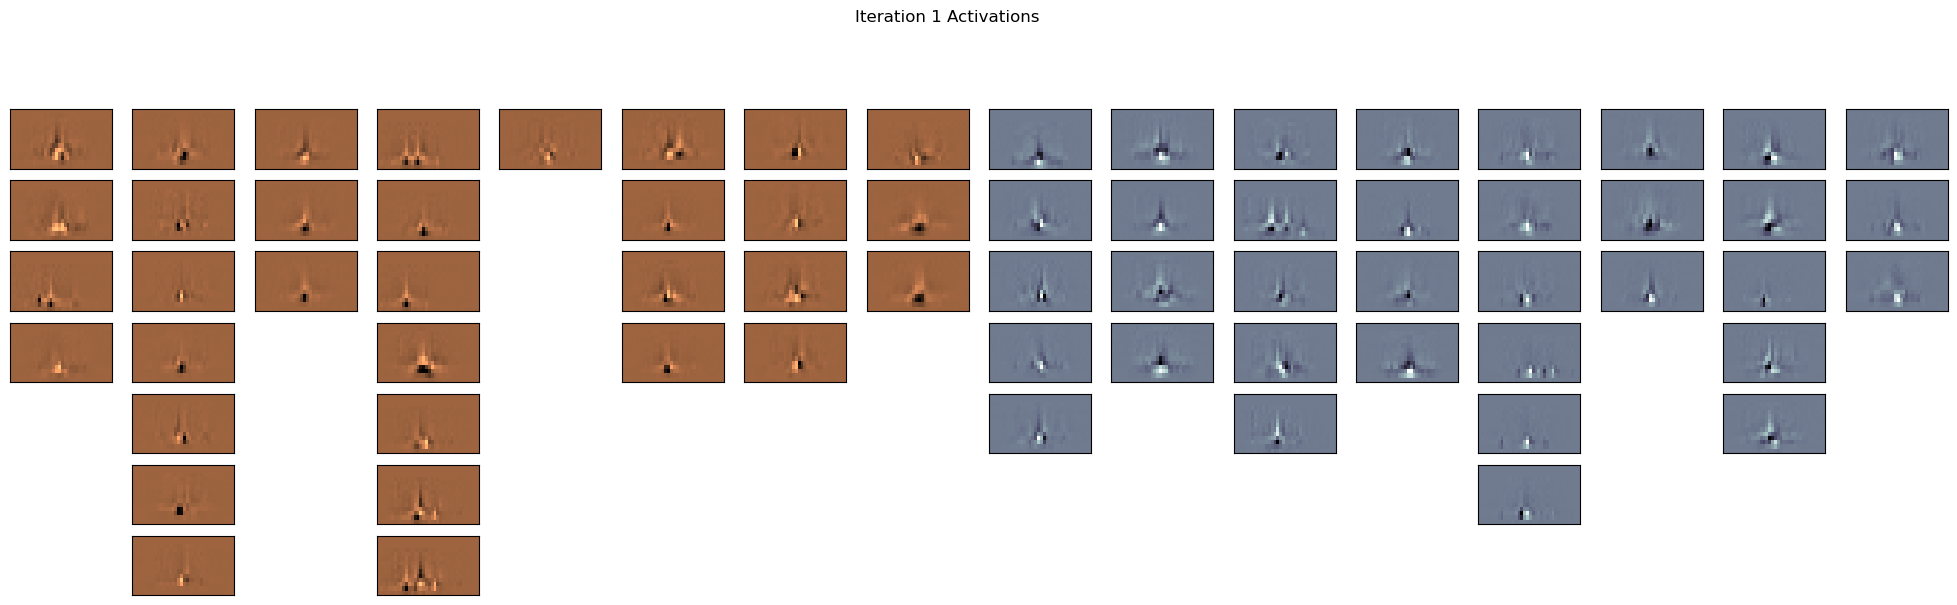

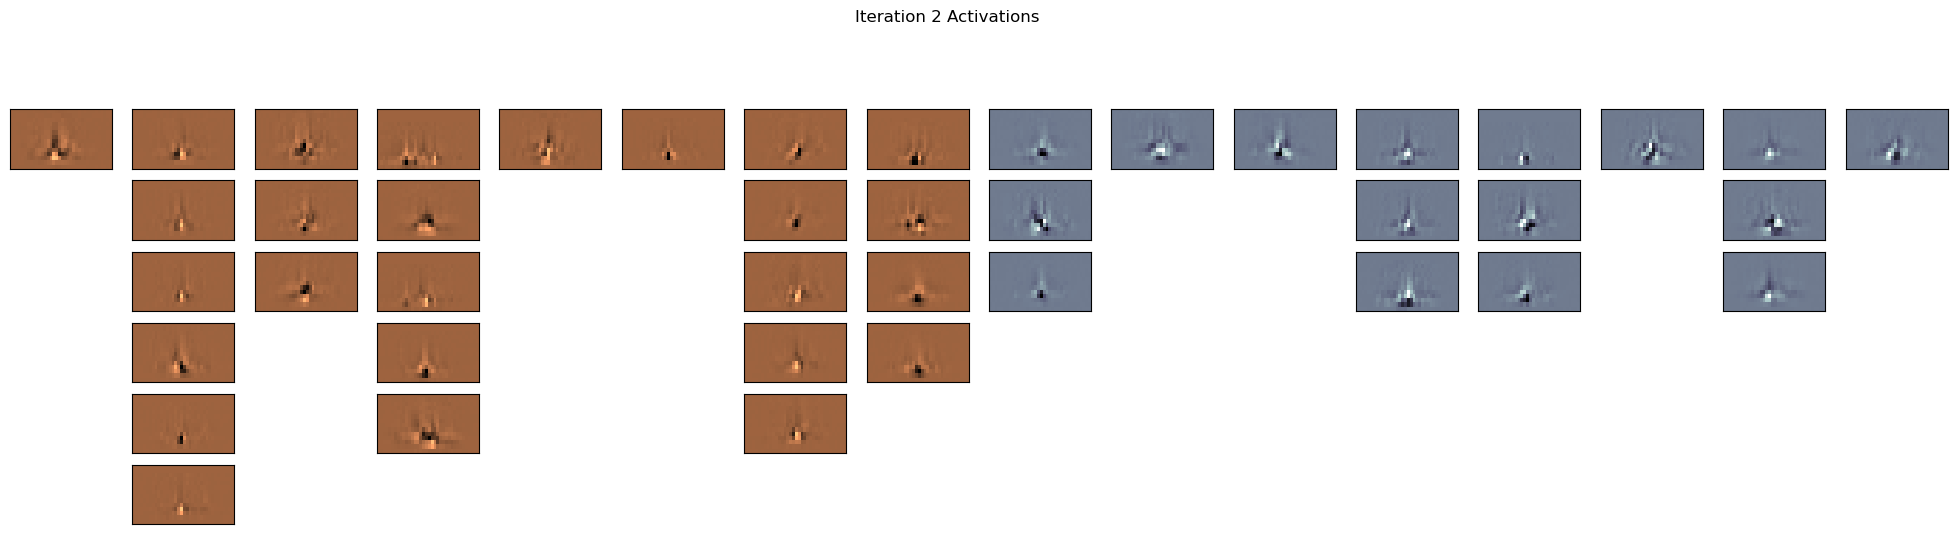

In [9]:
e.trials[0].model.NDN.plot_filters()

i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
        #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
        #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
        #    continue # skip if already done
        if li < 2:
            num_subunits = results_outputs.outputs[ni][li].shape[1]
            fig = plt.figure(figsize=(25,10))
            grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
            # plot the results jacobian
            imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
            imin = -imax
            for subunit in range(num_subunits):
                if subunit >= num_subunits//2: # inhibitory subunits
                    cmap = 'bone'
                else:
                    cmap = 'copper'

                cluster_idx = 0
                for label, cluster in cluster_labels_to_timepoints[i].items():
                    ax = fig.add_subplot(grid[cluster_idx, subunit])
                    im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],subunit,17,0].reshape(36,14).T
                    plot.imagesc(im.T, cmap=cmap, ax=ax, axis_labels=False)
                    cluster_idx += 1
                    ax.set_xticks([])
                    ax.set_yticks([])
                i += 1
            if li == 0:
                name = 'LGN Activations'
            elif li == 1:
                name = 'Proj Activations'
            plt.suptitle(name)
            plt.show()
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                num_subunits = results_outputs.outputs[ni][li].shape[2]
                fig = plt.figure(figsize=(25,10))
                grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
                # plot the results jacobian
                imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
                imin = -imax
                for subunit in range(num_subunits):
                    if subunit >= num_subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'

                    cluster_idx = 0
                    for label, cluster in cluster_labels_to_timepoints[i].items():
                        ax = fig.add_subplot(grid[cluster_idx, subunit])
                        im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],iter,subunit,17,0].reshape(36,14).T
                        plot.imagesc(im.T, cmap=cmap, ax=ax, axis_labels=False)
                        cluster_idx += 1
                        ax.set_xticks([])
                        ax.set_yticks([])
                    i += 1
                plt.suptitle('Iteration %d Activations' % iter)
                plt.show()

# wiring diagram

In [103]:
dirsel = dirsel_neurons[1]
nonsel = dirsel_neurons[5]

dirsel_weights = []
for cc in range(len(dirsel_neurons)):
    dirsel_weights.append(readout_weights[:,17,cc])
    # normalize the weights
    dirsel_weights[-1] = dirsel_weights[-1] / np.max(np.abs(dirsel_weights[-1]))

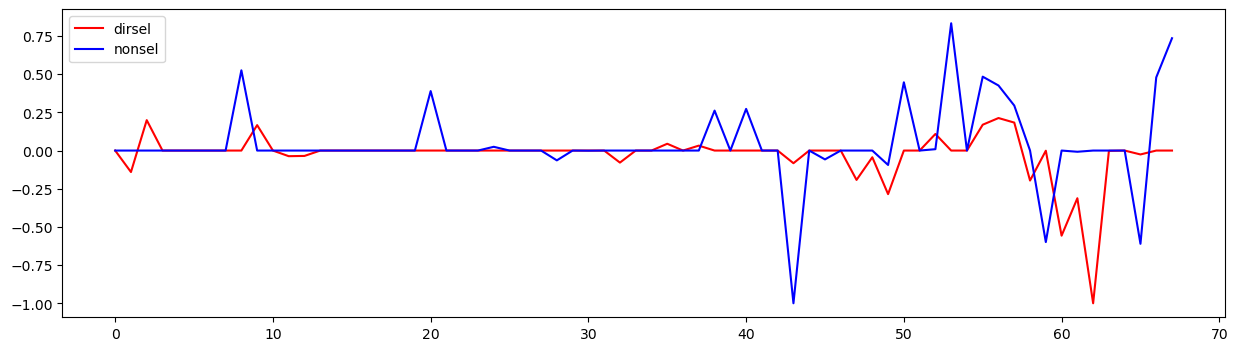

In [104]:
fig = plt.figure(figsize=(15,4))
plt.plot(dirsel_weights[0], color='r', label='dirsel')
plt.plot(dirsel_weights[5], color='b', label='nonsel')
plt.legend()
plt.show()

In [108]:
# def plot_jacobians(units_to_show=None, neuron=None):
#     if neuron is not None:
#         fig = plt.figure(figsize=(2,1))
#         plot.imagesc(pred[:,:,neuron], cmap='gray')
#         plt.title('Cell '+str(neuron)+', LL = %.4f' % e.trials[0].LLs[neuron])
#         plt.xlabel('Space')
#         plt.ylabel('Time')
#         plt.show()
#     
#     i = 0
#     for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
#         for li in range(len(results_outputs.outputs[ni])):
#             #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
#             #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
#             #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
#             #    continue # skip if already done
#             if li < 2:
#                 num_subunits = results_outputs.outputs[ni][li].shape[1]
#                 fig = plt.figure(figsize=(25,10))
#                 grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
#                 # plot the results jacobian
#                 imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
#                 imin = -imax
#                 for subunit in range(num_subunits):
#                     if subunit >= num_subunits//2: # inhibitory subunits
#                         cmap = 'bone'
#                     else:
#                         cmap = 'copper'
#                         
#                     if units_to_show is None or i in units_to_show:
#                         cluster_idx = 0
#                         for label, cluster in cluster_labels_to_timepoints[i].items():
#                             ax = fig.add_subplot(grid[cluster_idx, subunit])
#                             ax.set_xticks([])
#                             ax.set_yticks([])
#                             im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],subunit,17,0].reshape(36,14)
#                             plot.imagesc(im, cmap=cmap, ax=ax, axis_labels=False)
#                             cluster_idx += 1
#                     else:
#                         # show a blank image
#                         ax = fig.add_subplot(grid[0, subunit])
#                         ax.set_xticks([])
#                         ax.set_yticks([])
#                         ax.imshow(np.zeros((36,14)).T, cmap=cmap)
#                     i += 1
#                 if li == 0:
#                     name = 'LGN Activations'
#                 elif li == 1:
#                     name = 'Proj Activations'
#                 plt.suptitle(name)
#                 plt.show()
#             else:
#                 for iter in range(results_outputs.outputs[ni][li].shape[1]):
#                     num_subunits = results_outputs.outputs[ni][li].shape[2]
#                     fig = plt.figure(figsize=(25,10))
#                     grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
#                     # plot the results jacobian
#                     imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
#                     imin = -imax
#                     for subunit in range(num_subunits):
#                         if subunit >= num_subunits//2: # inhibitory subunits
#                             cmap = 'bone'
#                         else:
#                             cmap = 'copper'
# 
#                         if units_to_show is None or i in units_to_show:
#                             cluster_idx = 0
#                             for label, cluster in cluster_labels_to_timepoints[i].items():
#                                 ax = fig.add_subplot(grid[cluster_idx, subunit])
#                                 ax.set_xticks([])
#                                 ax.set_yticks([])
#                                 im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],iter,subunit,17,0].reshape(36,14)
#                                 plot.imagesc(im, cmap=cmap, ax=ax, axis_labels=False)
#                                 cluster_idx += 1
#                         else:
#                             # show a blank image
#                             ax = fig.add_subplot(grid[0, subunit])
#                             ax.set_xticks([])
#                             ax.set_yticks([])
#                             ax.imshow(np.zeros((36,14)).T, cmap=cmap)
#                         i += 1
#                     plt.suptitle('Iteration %d Activations' % iter)
#                     plt.show()

## plot function

In [161]:
def plot_jacobians(unit_weights=None, units_to_show=None, neuron=None, max_subunits=16):
    if neuron is not None:
        fig = plt.figure(figsize=(2,1))
        plot.imagesc(pred[:,:,neuron], cmap='gray')
        plt.title('Cell '+str(neuron)+', LL = %.4f' % e.trials[0].LLs[neuron])
        plt.xlabel('Space')
        plt.ylabel('Time')
        plt.show()

    fig = plt.figure(figsize=(25,10))
    grid = matplotlib.gridspec.GridSpec(num_clusters,max_subunits)

    i = 0
    unit_to_show = 0
    for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
        for li in range(len(results_outputs.outputs[ni])):
            if li == 0:
                name = 'LGN'
            elif li == 1:
                name = 'Proj'
                
            #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
            #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
            #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
            #    continue # skip if already done
            if li < 2:
                num_subunits = results_outputs.outputs[ni][li].shape[1]
                
                # plot the results jacobian
                imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
                imin = -imax
                for subunit in range(num_subunits):
                    if subunit >= num_subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'

                    if units_to_show is None or i in units_to_show:
                        cluster_idx = 0
                        for label, cluster in cluster_labels_to_timepoints[i].items():
                            ax = fig.add_subplot(grid[cluster_idx, unit_to_show])
                            ax.set_xticks([])
                            ax.set_yticks([])
                            im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],subunit,17,0].reshape(36,14).T
                            # normalize the image to be between 0-1
                            #im = (im - imin) / (imax - imin)
                            # weight the image by the unit weight
                            #im *= abs(unit_weights[i])
                            #ax.imshow(im, cmap=cmap, origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1)
                            plot.imagesc(im.T, cmap=cmap, ax=ax, axis_labels=False)
                            # label the first cluster
                            if cluster_idx == 0:
                                ax.set_title(name + ' [%.2f]' % unit_weights[i])
                            cluster_idx += 1
                        unit_to_show += 1
                    i += 1
            else:
                for iter in range(results_outputs.outputs[ni][li].shape[1]):
                    name = 'Iter %d' % iter
                    num_subunits = results_outputs.outputs[ni][li].shape[2]
                    # plot the results jacobian
                    imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
                    imin = -imax
                    for subunit in range(num_subunits):
                        if subunit >= num_subunits//2: # inhibitory subunits
                            cmap = 'bone'
                        else:
                            cmap = 'copper'

                        if units_to_show is None or i in units_to_show:
                            cluster_idx = 0
                            for label, cluster in cluster_labels_to_timepoints[i].items():
                                ax = fig.add_subplot(grid[cluster_idx, unit_to_show])
                                ax.set_xticks([])
                                ax.set_yticks([])
                                im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],iter,subunit,17,0].reshape(36,14).T
                                # normalize the image to be between 0-1
                                #im = (im - imin) / (imax - imin)
                                # weight the image by the unit weight
                                #im *= abs(unit_weights[i])
                                #ax.imshow(im, cmap=cmap, origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1)
                                plot.imagesc(im.T, cmap=cmap, ax=ax, axis_labels=False)
                                # label the first cluster
                                if cluster_idx == 0:
                                    ax.set_title(name + ' [%.2f]' % unit_weights[i])
                                cluster_idx += 1
                            unit_to_show += 1
                        i += 1        
    plt.show()

## neuron subunits

Direction-selective cell 0


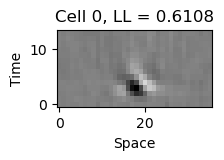

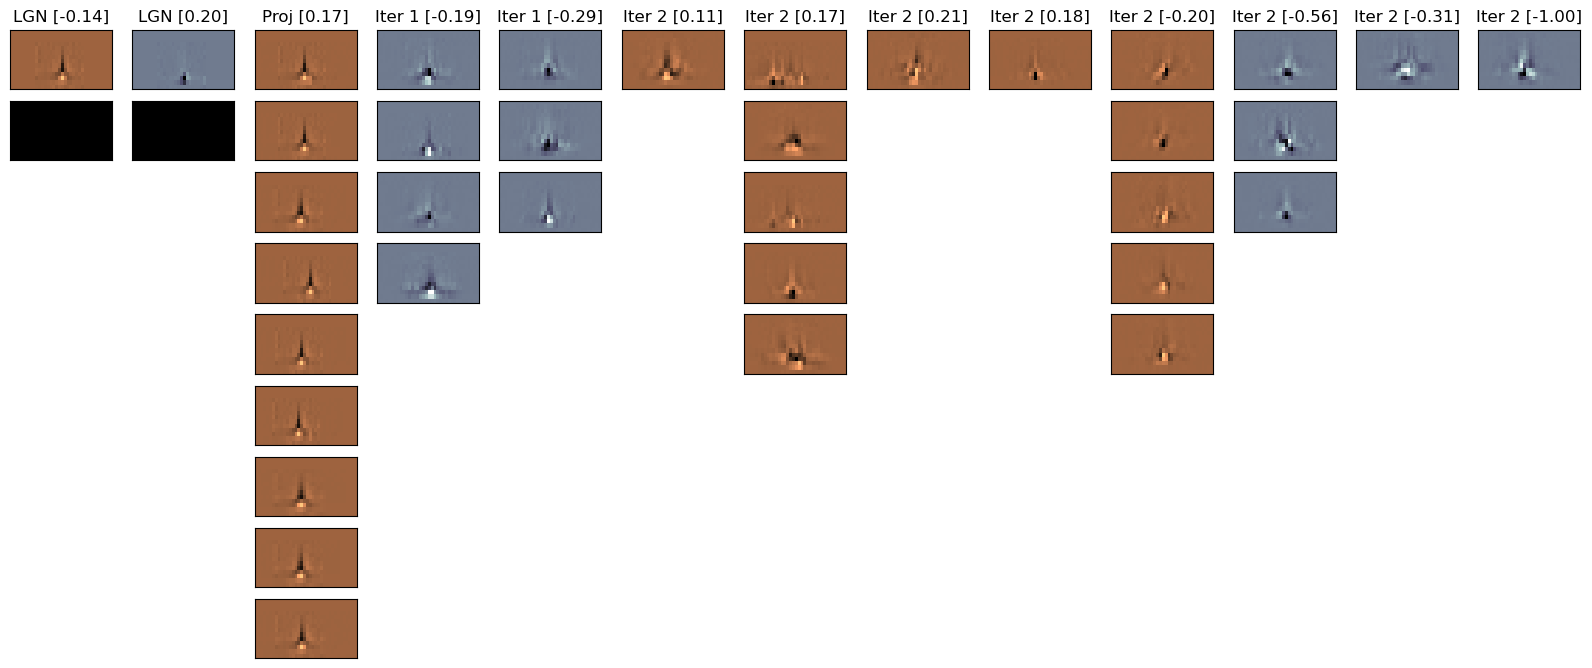

Direction-selective cell 2


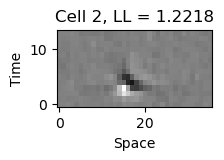

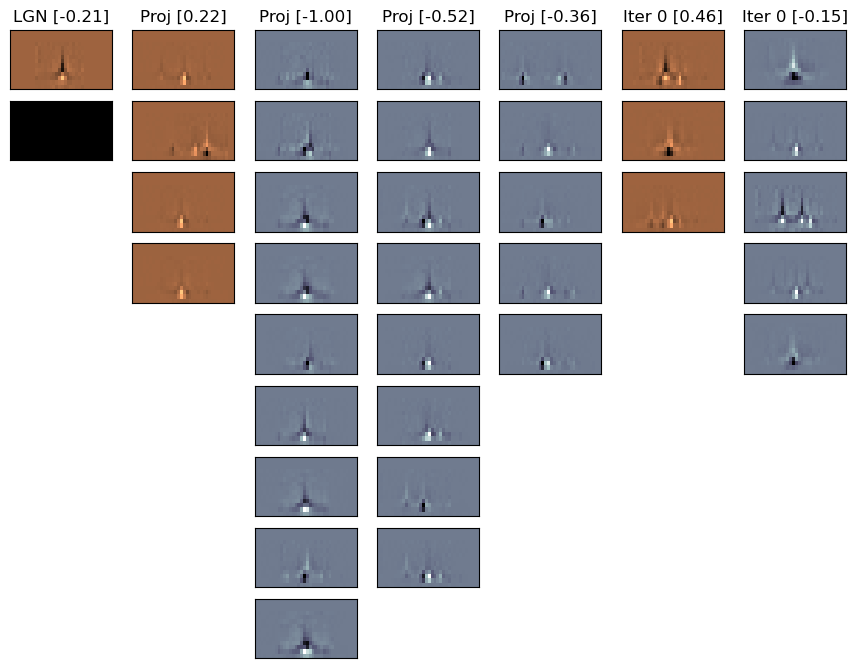

Direction-selective cell 63


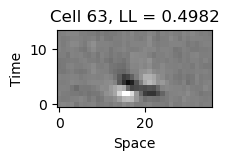

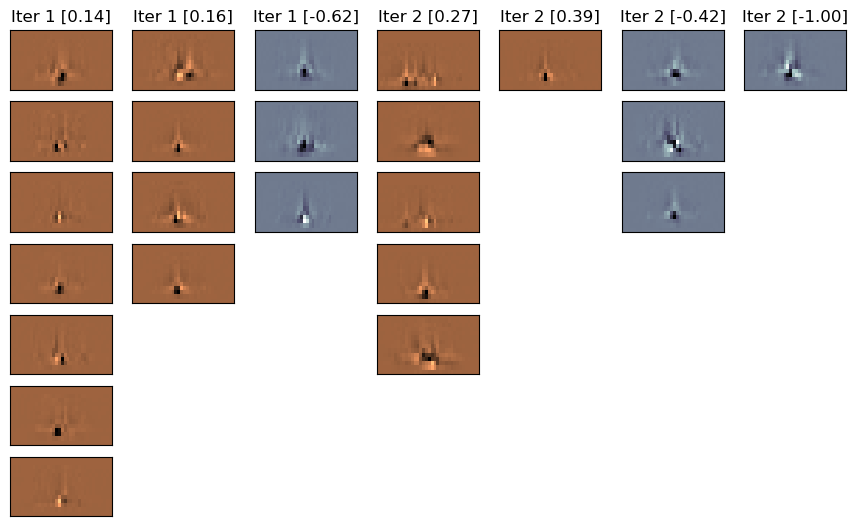

Direction-selective cell 87


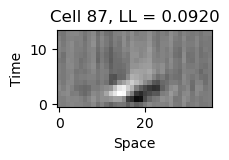

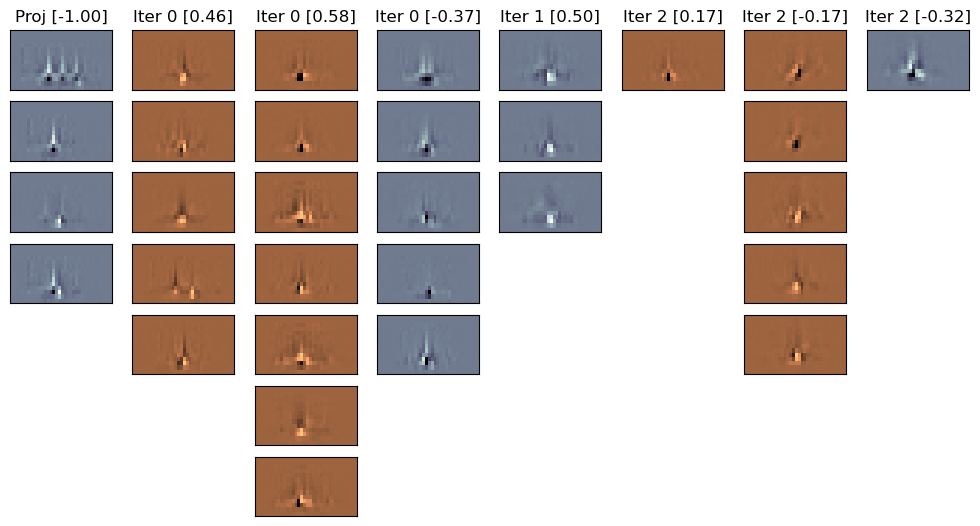

Non-selective cell 1


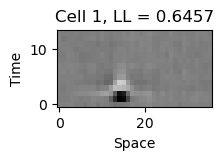

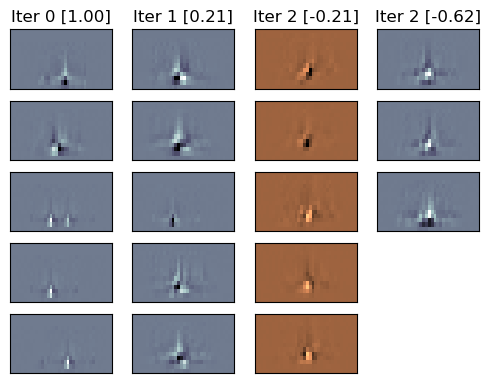

Non-selective cell 3


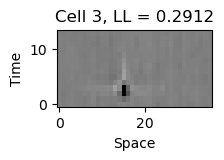

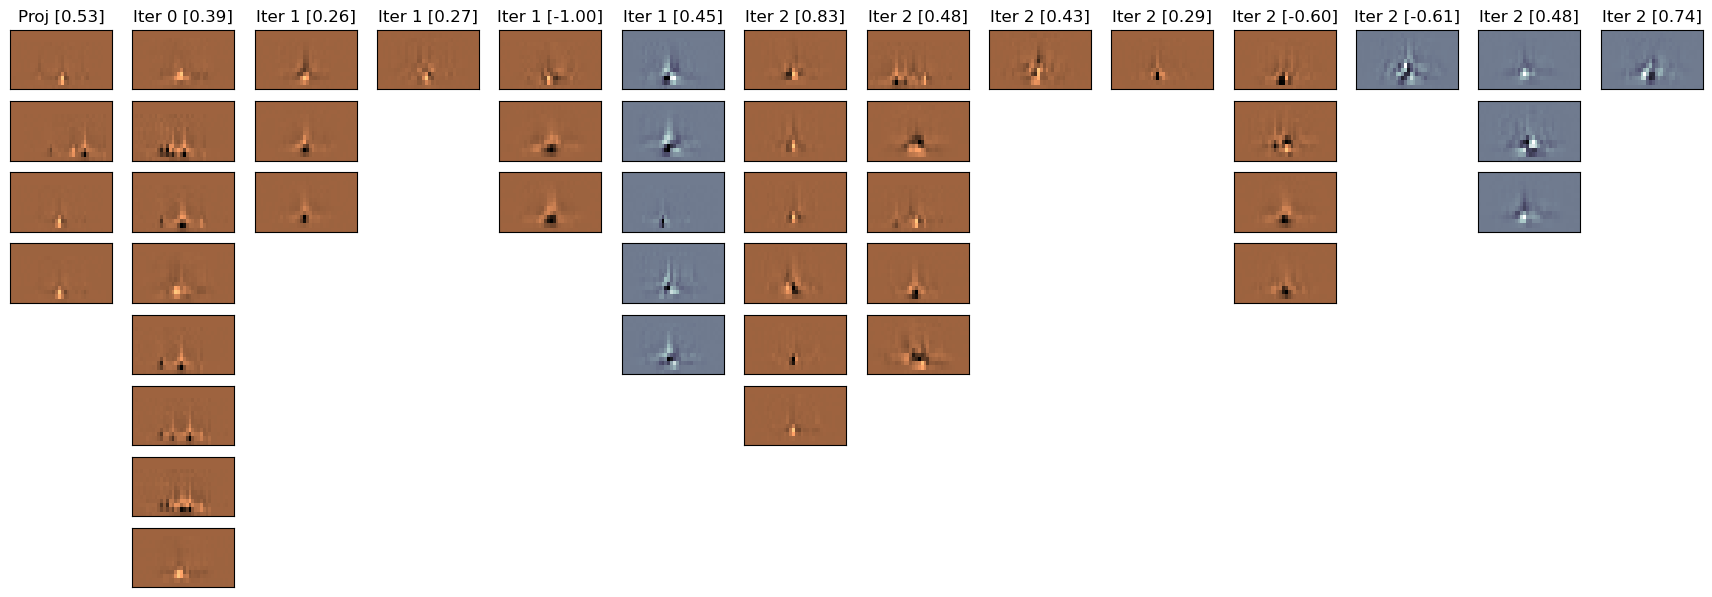

Non-selective cell 36


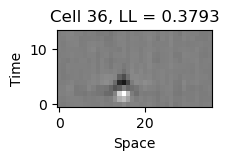

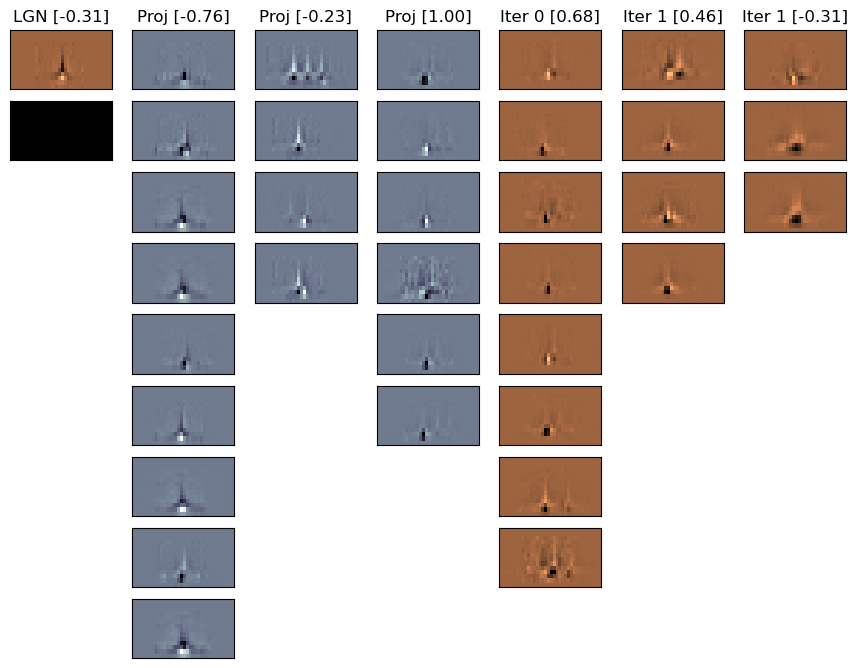

Non-selective cell 89


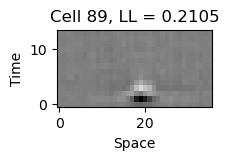

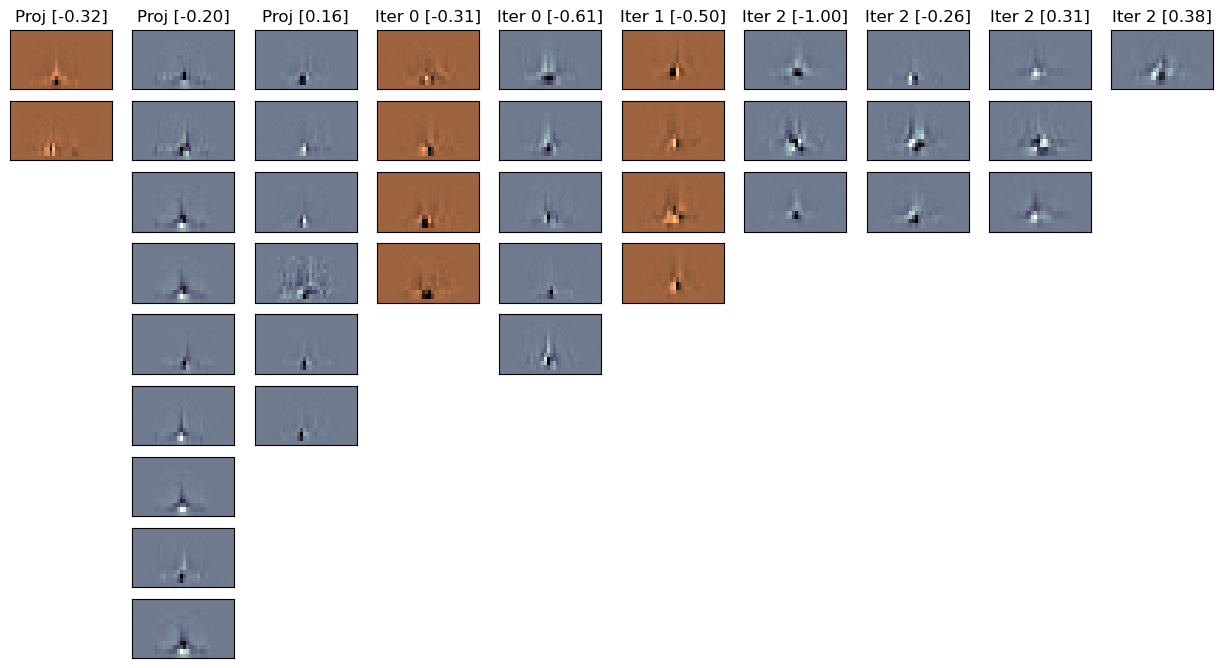

In [190]:
for i in range(len(dirsel_neurons)):
    typ = 'Direction-selective' if i < 4 else 'Non-selective'
    print(typ + ' cell %d' % dirsel_neurons[i])
    plot_jacobians(unit_weights=dirsel_weights[i], units_to_show=np.argwhere(np.abs(dirsel_weights[i]) > 0.1), neuron=dirsel_neurons[i])

## neuron subunit connections

In [186]:
# TODO: draw connections between the subunits and what projects to each one
#       this will give us a sense of how the subunits are creating the function they are showing

def subunit_connections():
    ...

[4, 36, 1, 4]

In [189]:
model = e.trials[0].model
weights = []
for ni in range(len(model.networks[:-1])):
    for li in range(len(model.networks[ni].layers)):
        normalized_weights = model.networks[ni].layers[li].weights / np.max(np.abs(model.networks[ni].layers[li].weights))
        weights.append(normalized_weights)
        print(model.NDN.networks[ni].layers[li].input_dims, '-->', model.NDN.networks[ni].layers[li].output_dims)

[1, 36, 1, 14] --> [4, 36, 1, 4]
[4, 36, 1, 4] --> [16, 36, 1, 4]
[16, 36, 1, 4] --> [48, 36, 1, 1]


In [177]:
for weight in weights:
    print(weight.shape)

(17, 11, 4)
(4, 17, 16)
(16, 7, 2, 16)


# spatial and temporal measures

In [450]:
import skimage
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu, threshold_niblack, threshold_multiotsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

/tmp/ipykernel_173711/2526718735.py:23: RuntimeWarning: invalid value encountered in divide
  im = (im - np.min(im)) / (np.max(im) - np.min(im))


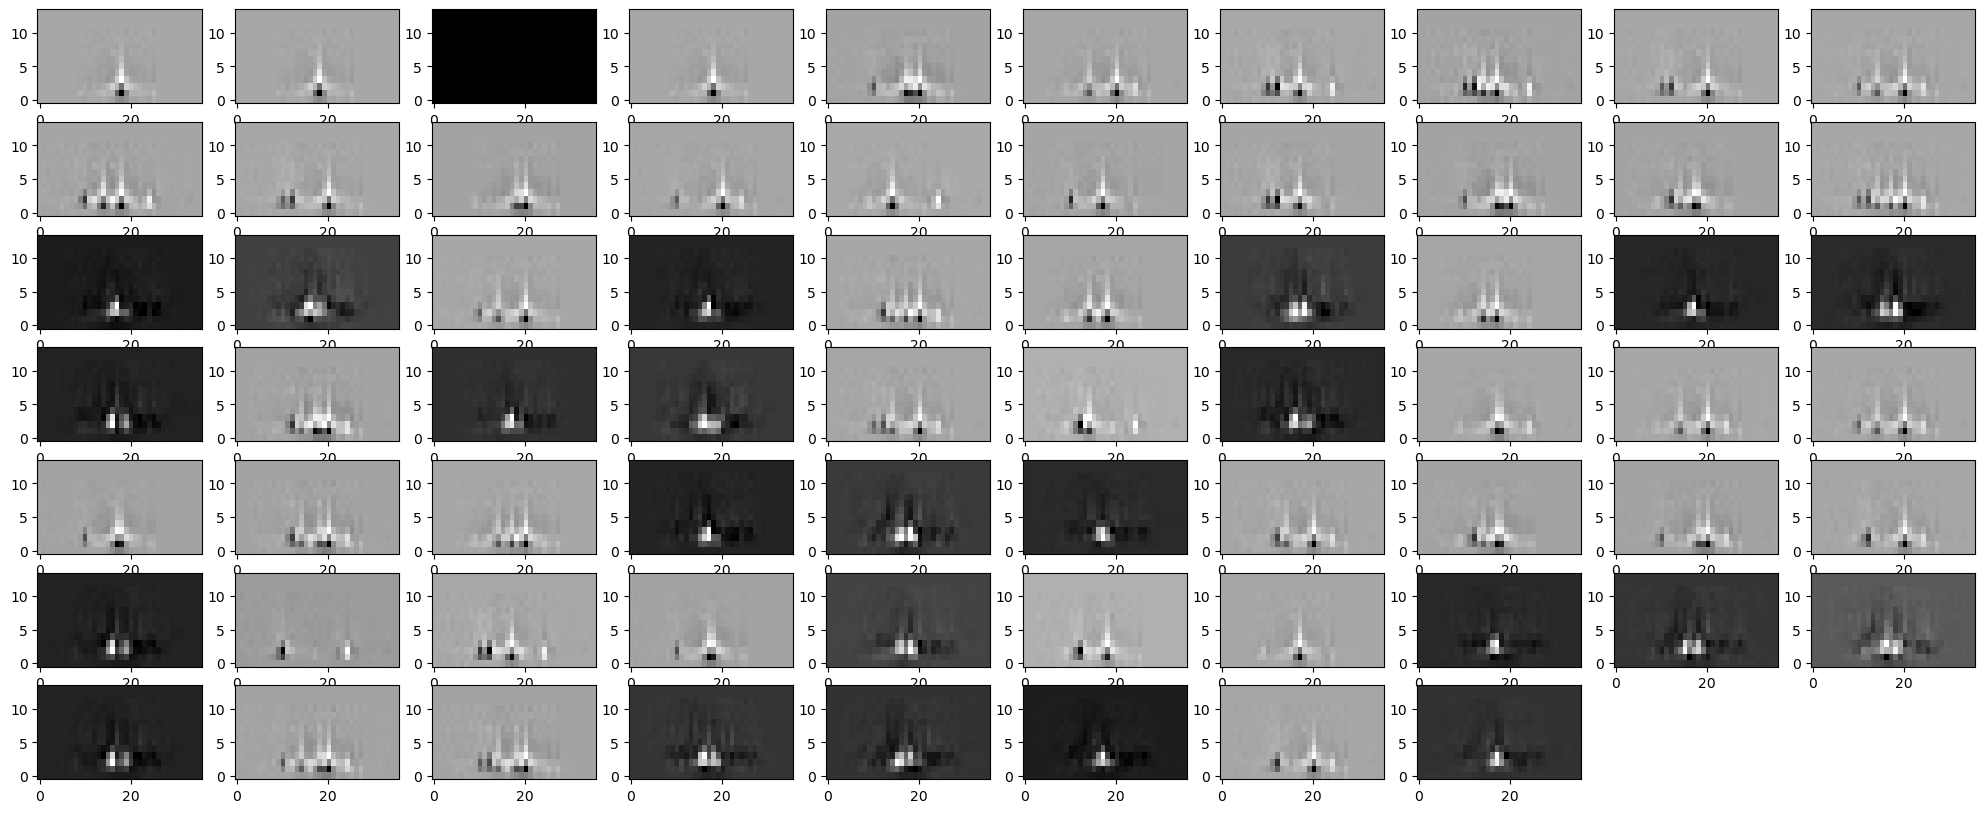

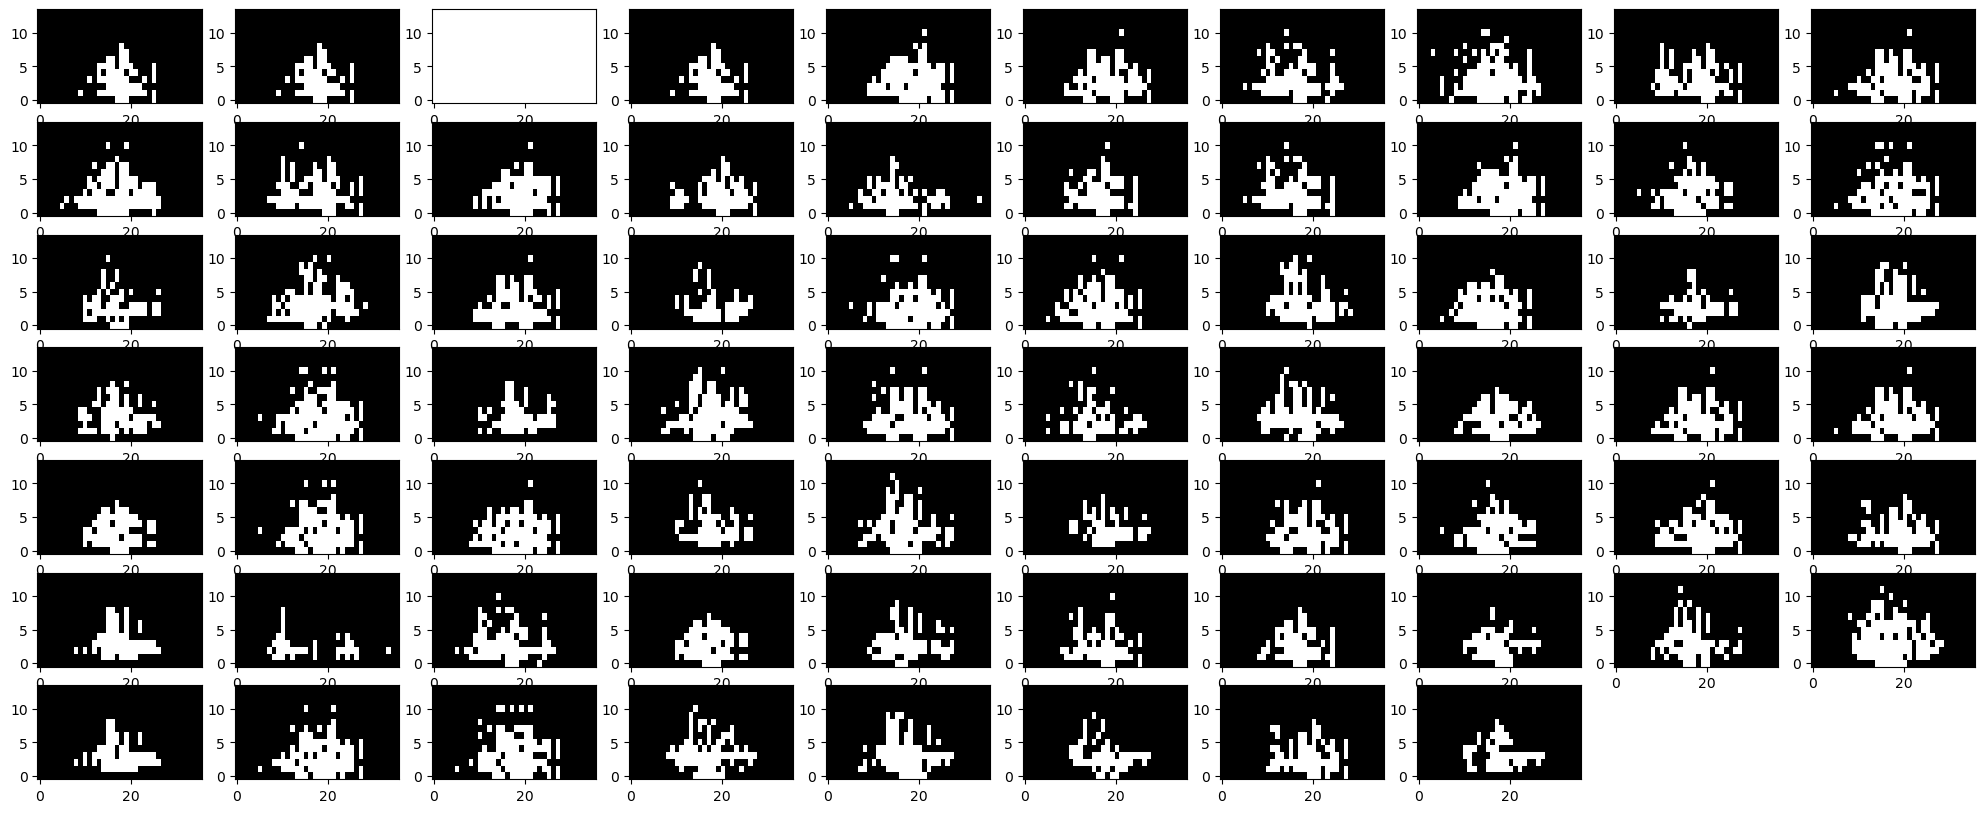

In [497]:
def imshow(im):
    plt.imshow(im, cmap='gray', origin='lower', interpolation='none', aspect='auto')

ims = []
fig = plt.figure(figsize=(25,10))
rows,cols = 7,10
grid = matplotlib.gridspec.GridSpec(rows,cols)
for idx,i in enumerate(range(68)):
    if i < 20: # it is not-iterative
        ims.append(results_jacobians[i].jacobian.jacobians[0][0][0,0,17,0].reshape(36,14).T)
    else: # it is an iterative one
        ims.append(results_jacobians[i].jacobian.jacobians[0][0][0,0,0,17,0].reshape(36,14).T)
    row,col = np.unravel_index(idx, (rows,cols))
    ax = fig.add_subplot(grid[row,col])
    imshow(ims[-1])

fig = plt.figure(figsize=(25,10))
rows,cols = 7,10
grid = matplotlib.gridspec.GridSpec(rows,cols)
for i in range(len(ims)):
    im = ims[i]
    im = np.abs(im)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    mean = np.mean(im)
    std = np.std(im)
    bg = im < mean + 1.1*std
    mn = np.min(im)
    mx = np.max(im)
    bg = im < mn + 0.04*(mx-mn)
    #bg = closing(bg, square(3)) # fill in holes
    #cleared = clear_border(bg) # remove artifacts connected to image border
    fg = 1 - bg
    # detect the largest blob in the fg
    # label_image = label(fg)
    # props = skimage.measure.regionprops(label_image)
    # areas = [prop.area for prop in props]
    # largest_blob = areas[np.argsort(areas)[-2]]
    # segmented_image = label_image == largest_blob
    #im = im * segmented_image

    row,col = np.unravel_index(i, (rows,cols))
    ax = fig.add_subplot(grid[row,col])
    ax.imshow(fg, cmap='gray', origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1)

# 
# fig = plt.figure(figsize=(25,10))
# rows,cols = 7,10
# grid = matplotlib.gridspec.GridSpec(rows,cols)
# for i in range(len(ims)):
#     im = ims[i]
#     im = (im - np.min(im)) / (np.max(im) - np.min(im))
#     row,col = np.unravel_index(i, (rows,cols))
#     ax = fig.add_subplot(grid[row,col])
# 
#     try:
#     #     #im = im**2
#     #     mn = np.min(im)
#     #     mx = np.max(im)
#     #     thresholds = threshold_multiotsu(im)
#     #     regions = np.digitize(im, bins=thresholds)
#         ax.hist(im.flatten(), bins=1000)
#     except:
#         regions = np.zeros_like(im)    
#     #ax.imshow(regions, cmap='gray', origin='lower', interpolation='none', aspect='auto')

## simple approach

In [6]:
class ResultsJacobian:
    def __init__(self, jacobian, times):
        self.jacobian = jacobian
        self.times = times

In [8]:
# measure spatial and temporal extents of subunits
lgn = []
proj = []
iter0 = []
iter1 = []
iter2 = []
iter3 = []
iter4 = []
for idx,i in enumerate(range(100)):
    with open('./results_iter_exps12_5iters_jacobians/'+str(i)+'.pkl', 'rb') as f:
        results_jacobians = pickle.load(f)
    if i < 4: # it is not-iterative
        lgn.append(results_jacobians.jacobian.jacobians[0][0][:,i,17,0])
    elif i < 20:
        proj.append(results_jacobians.jacobian.jacobians[0][0][:,i-4,17,0])
    elif i < 36:
        iter0.append(results_jacobians.jacobian.jacobians[0][0][:,0,i-20,17,0])
    elif i < 52:
        iter1.append(results_jacobians.jacobian.jacobians[0][0][:,1,i-36,17,0])
    elif i < 68:
        iter2.append(results_jacobians.jacobian.jacobians[0][0][:,2,i-52,17,0])
    # elif i < 84:
    #     iter3.append(results_jacobians.jacobian.jacobians[0][0][:,3,i-68,17,0])
    # elif i < 100:
    #     iter4.append(results_jacobians.jacobian.jacobians[0][0][:,4,i-84,17,0])

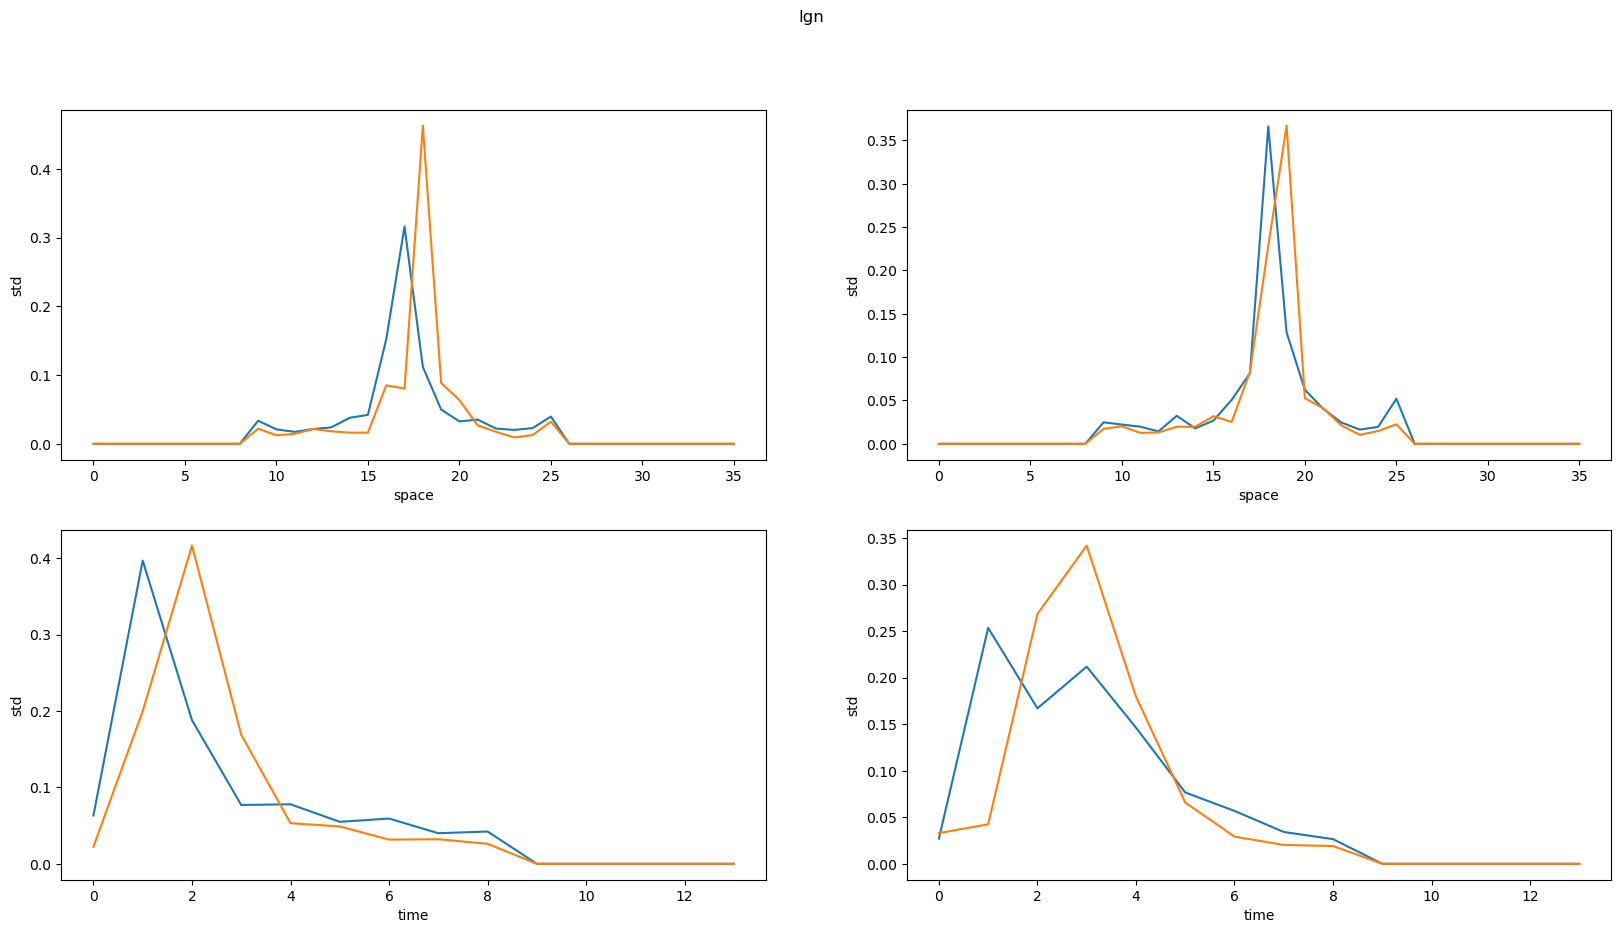

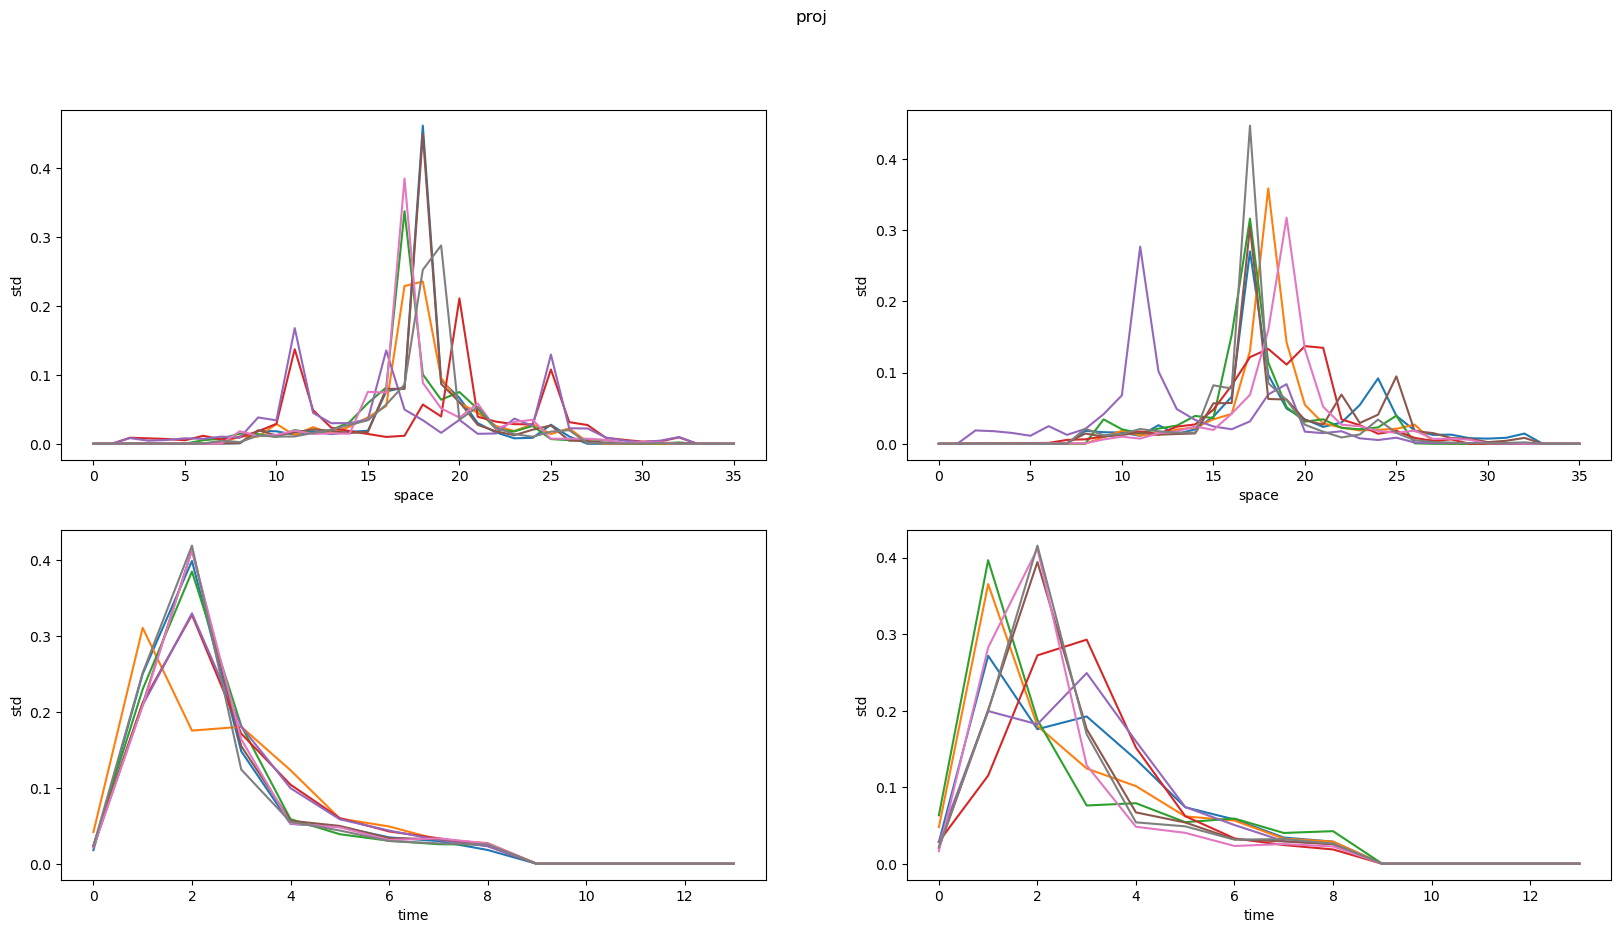

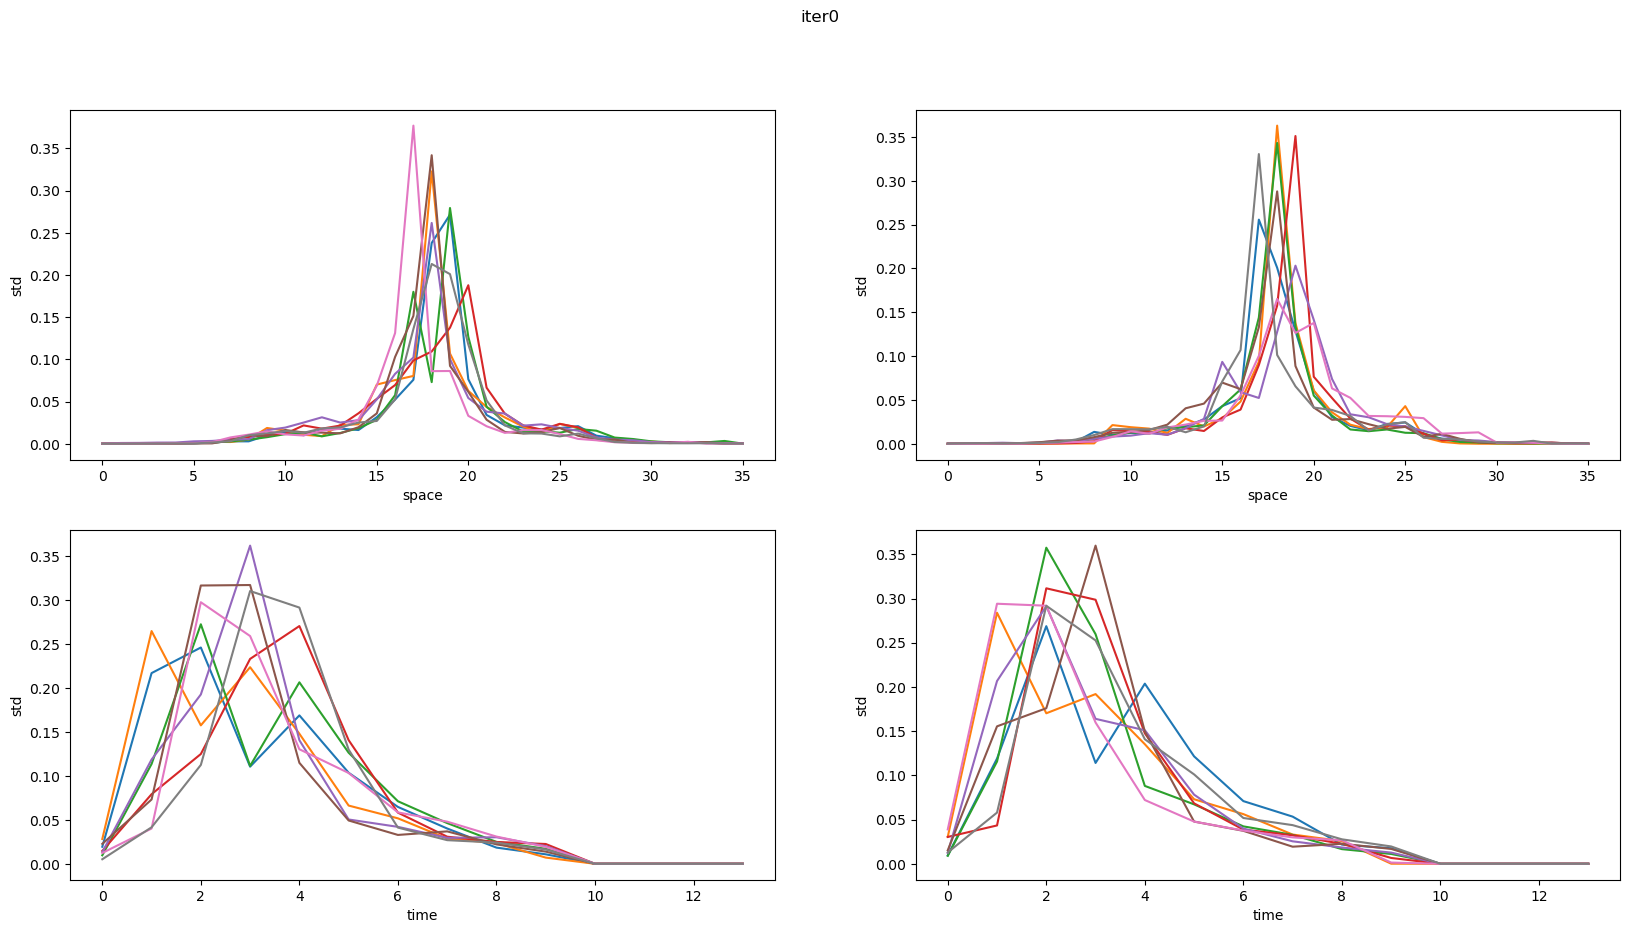

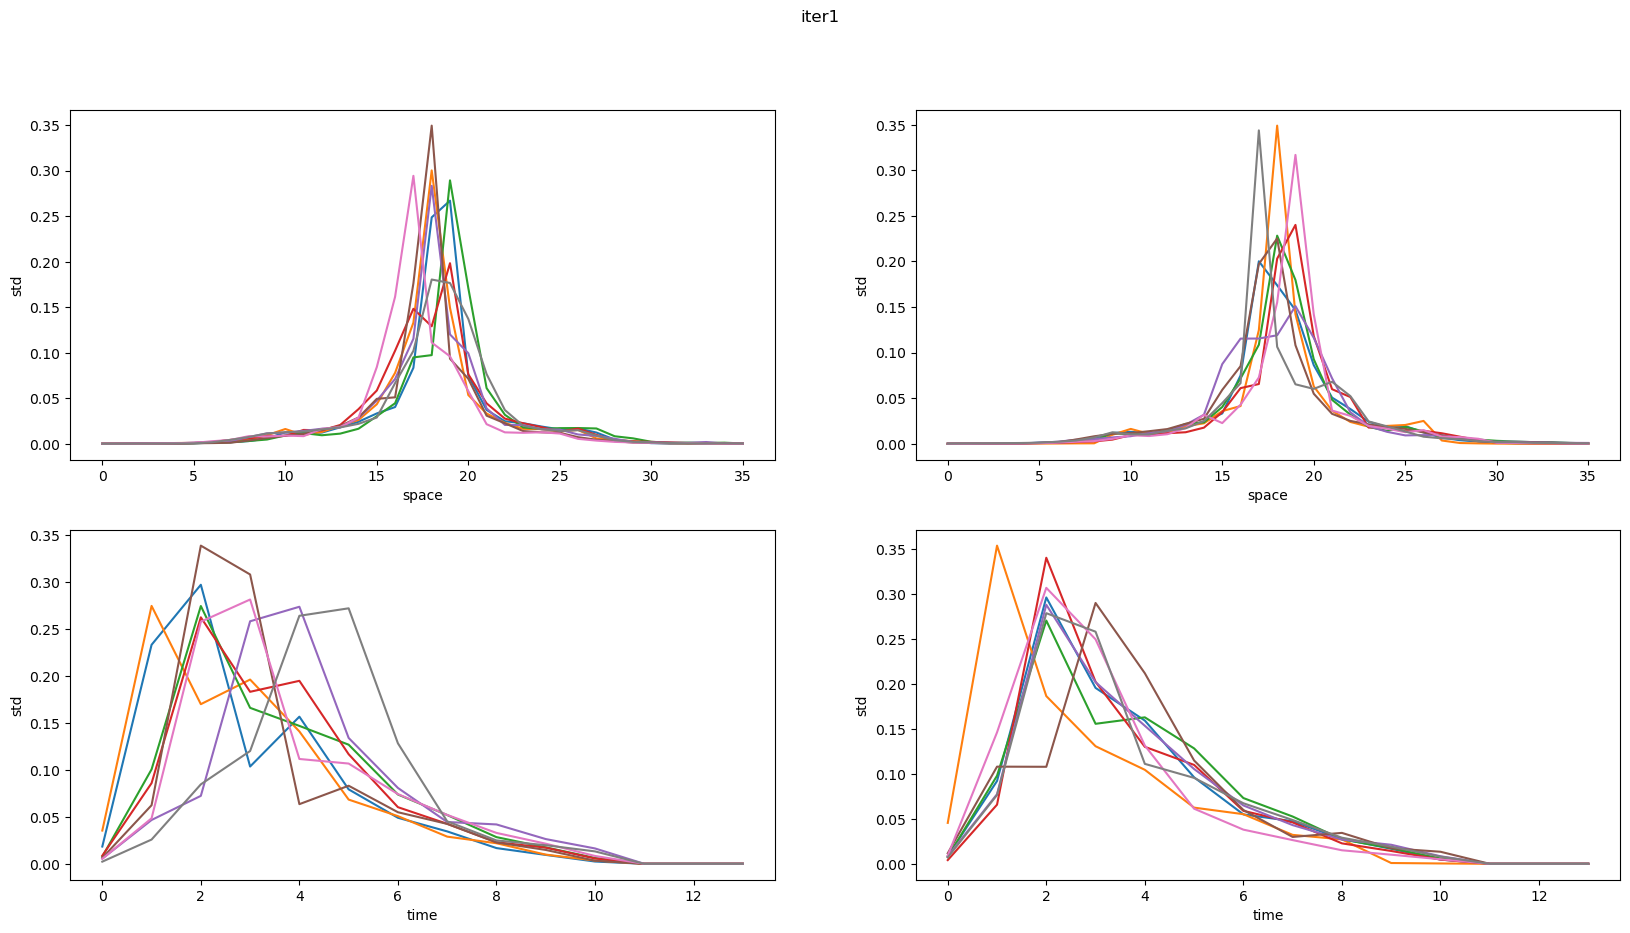

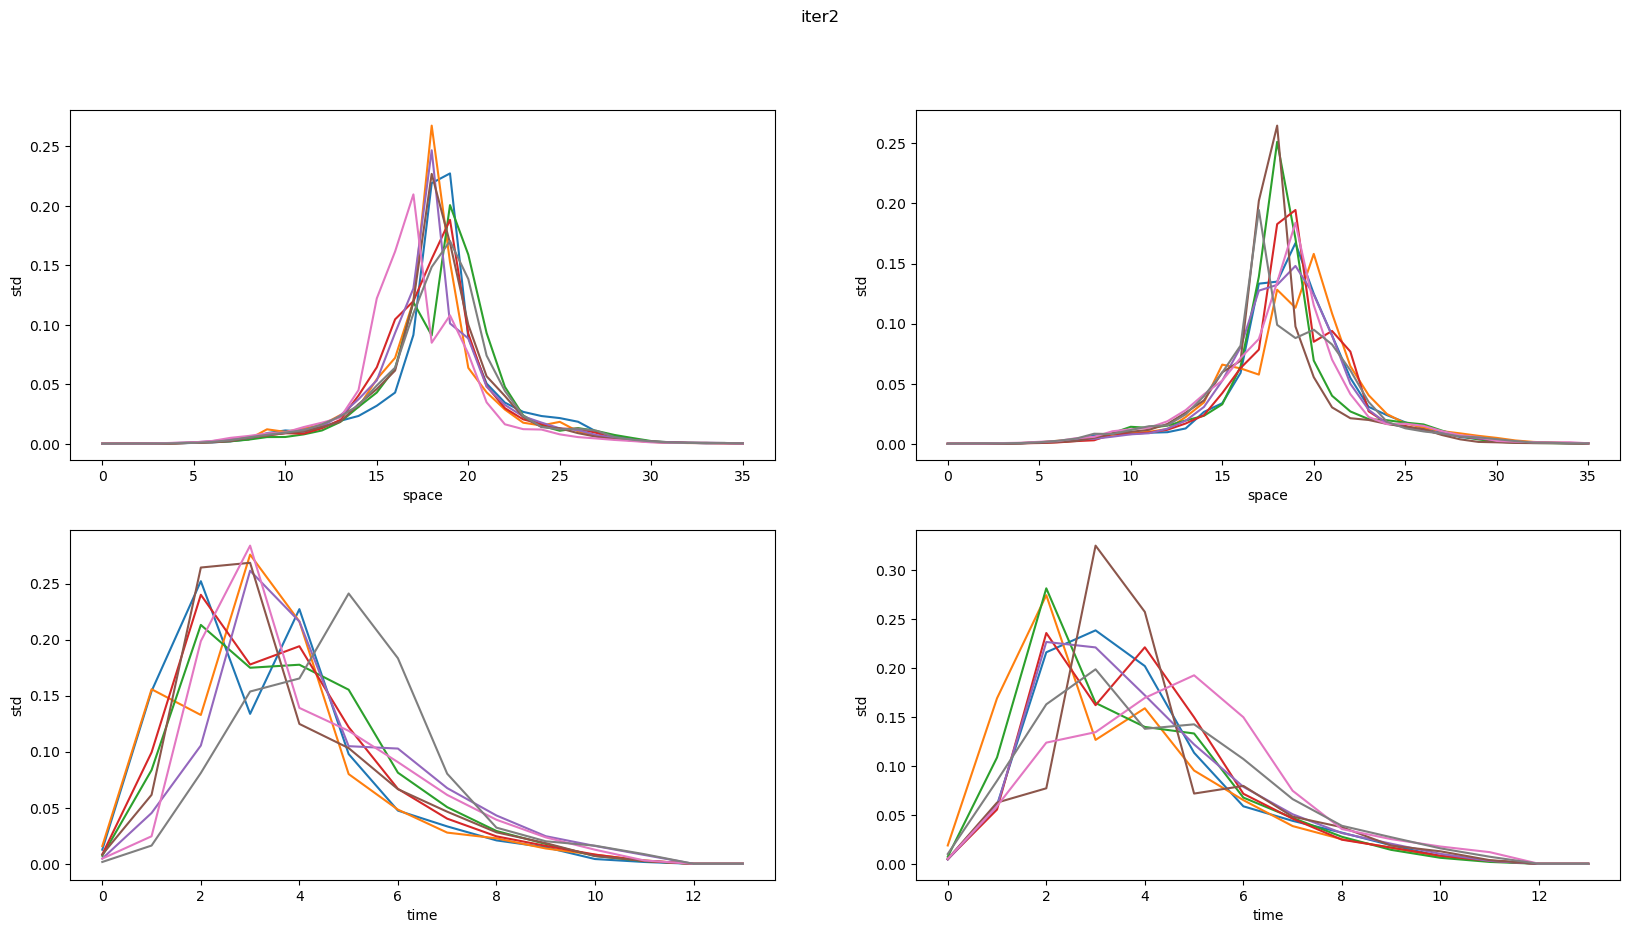

In [9]:
for ims,name in zip([lgn, proj, iter0, iter1, iter2], ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
#for ims,name in zip([lgn, proj, iter0, iter1, iter2, iter3, iter4], ['lgn', 'proj', 'iter0', 'iter1', 'iter2', 'iter3', 'iter4']):
    ws = []
    hs = []
    fig = plt.figure(figsize=(20,10))
    grid = matplotlib.gridspec.GridSpec(2,2)
    ax = fig.add_subplot(grid[0,0])
    for i in range(len(ims)//2):
        im = ims[i].reshape(100,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        # normalize the ksp to sum to 1
        ksp = ksp / np.sum(ksp)
        ax.plot(ksp)
        ax.set_xlabel('space')
        ax.set_ylabel('std')
    ax = fig.add_subplot(grid[0,1])
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(100,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        # normalize the ksp to sum to 1
        ksp = ksp / np.sum(ksp)
        ax.plot(ksp)
        ax.set_xlabel('space')
        ax.set_ylabel('std')

    ax = fig.add_subplot(grid[1,0])
    for i in range(len(ims)//2):
        im = ims[i].reshape(100,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        # normalize the ksp to sum to 1
        kt = kt / np.sum(kt)
        ax.plot(kt)
        ax.set_xlabel('time')
        ax.set_ylabel('std')
    ax = fig.add_subplot(grid[1,1])
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(100,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        # normalize the ksp to sum to 1
        kt = kt / np.sum(kt)
        ax.plot(kt)
        ax.set_xlabel('time')
        ax.set_ylabel('std')
    plt.suptitle(name)

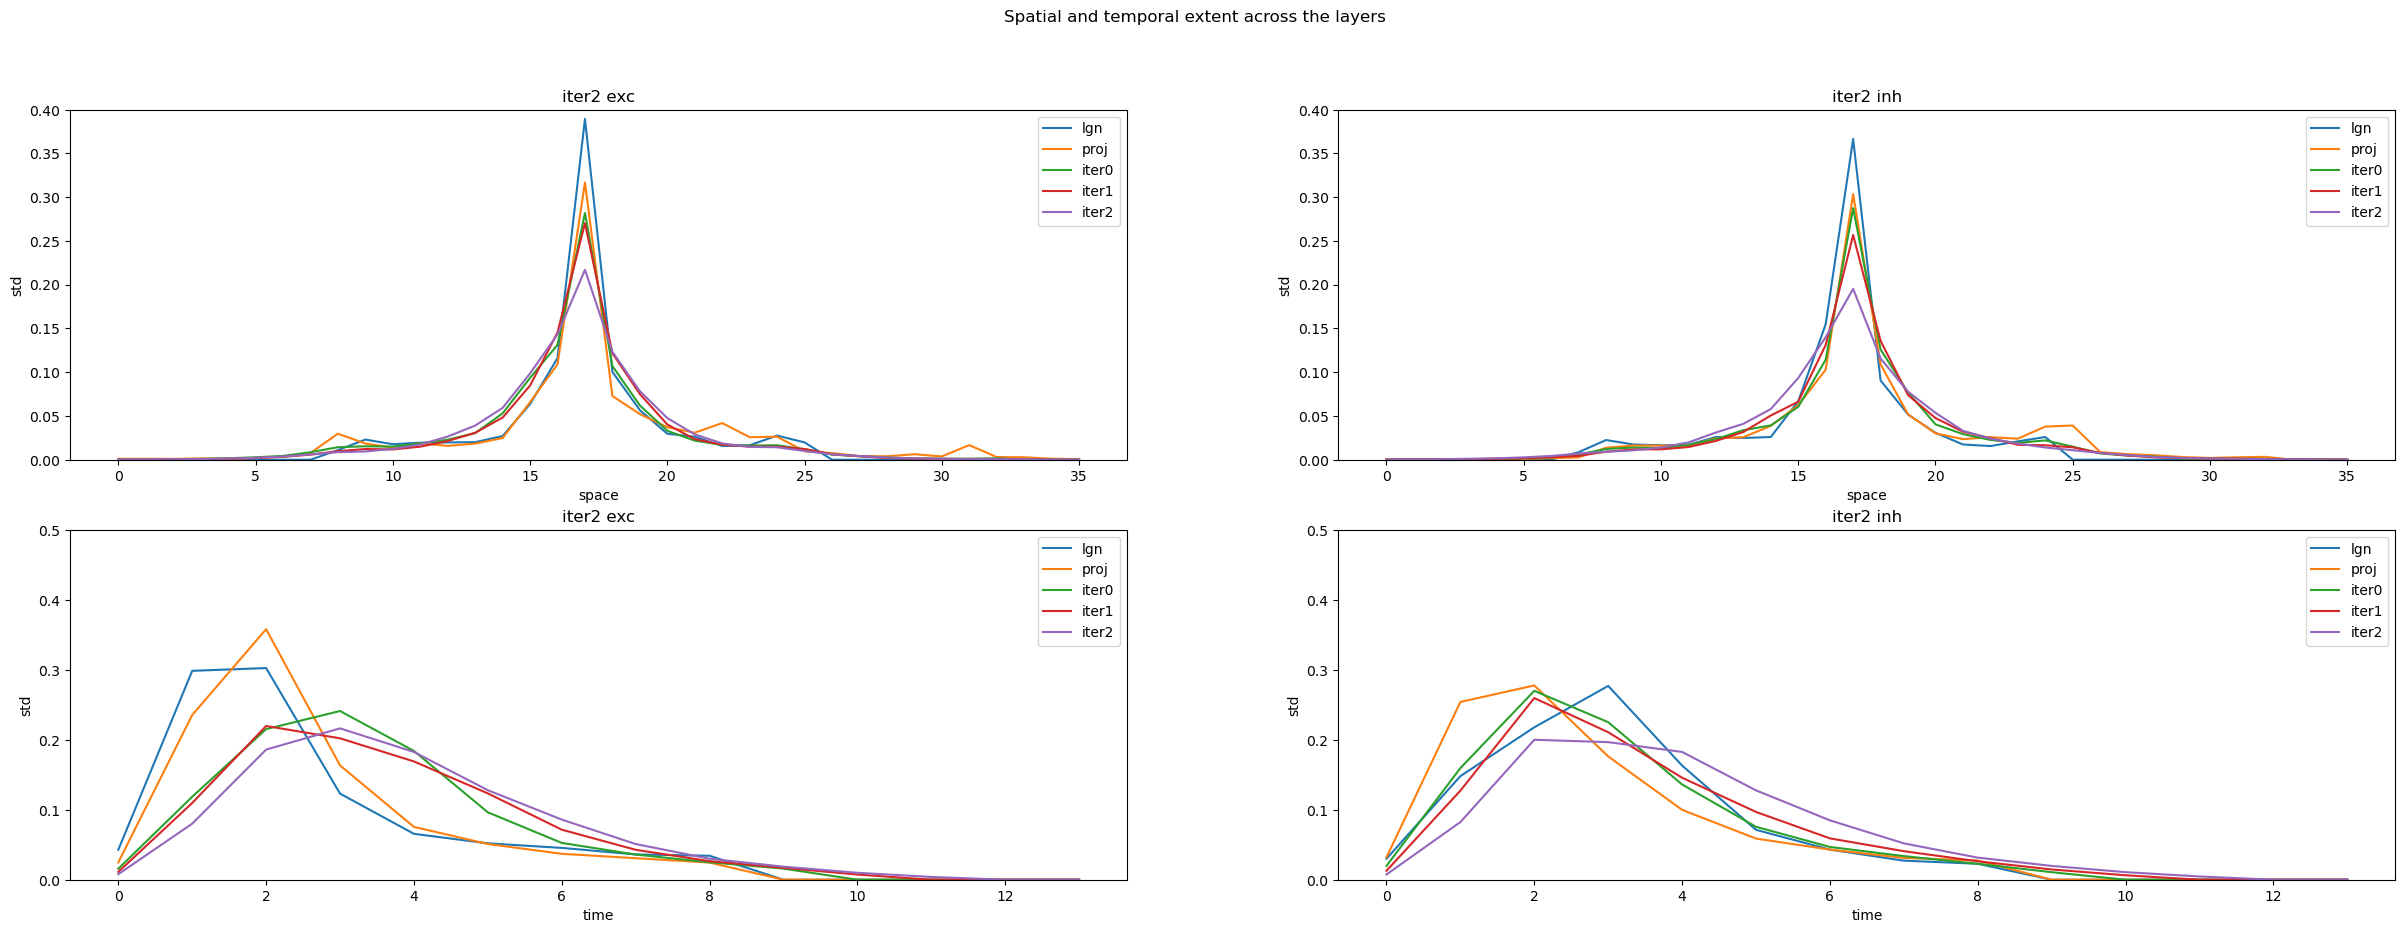

In [10]:
fig = plt.figure(figsize=(30,10))
grid = matplotlib.gridspec.GridSpec(2,2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[1,1])
layer_idx = 0
for ims,name in zip([lgn, proj, iter0, iter1, iter2], ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
#for ims,name in zip([lgn, proj, iter0, iter1, iter2, iter3, iter4], ['lgn', 'proj', 'iter0', 'iter1', 'iter2', 'iter3', 'iter4']):
    ws = []
    hs = []
    ksps = []
    for i in range(len(ims)//2):
        im = ims[i].reshape(100,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax0.plot(np.mean(ksps, axis=0), label=name)
    ax0.set_title(name + ' exc')
    ax0.set_xlabel('space')
    ax0.set_ylabel('std')
    ax0.set_ylim([0,0.4])
    ax0.legend()
    
    ksps = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(100,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax1.plot(np.mean(ksps, axis=0), label=name)
    ax1.set_title(name + ' inh')
    ax1.set_xlabel('space')
    ax1.set_ylabel('std')
    ax1.set_ylim([0,0.4])
    ax1.legend()

    kts = []
    for i in range(len(ims)//2):
        im = ims[i].reshape(100,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax2.plot(np.mean(kts, axis=0), label=name)
    ax2.set_title(name + ' exc')
    ax2.set_xlabel('time')
    ax2.set_ylabel('std')
    ax2.set_ylim([0,0.5])
    ax2.legend()

    kts = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(100,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax3.plot(np.mean(kts, axis=0), label=name)
    ax3.set_title(name + ' inh')
    ax3.set_xlabel('time')
    ax3.set_ylabel('std')
    ax3.set_ylim([0,0.5])
    ax3.legend()
    plt.suptitle(name)
    layer_idx += 2
_ = plt.suptitle('Spatial and temporal extent across the layers')

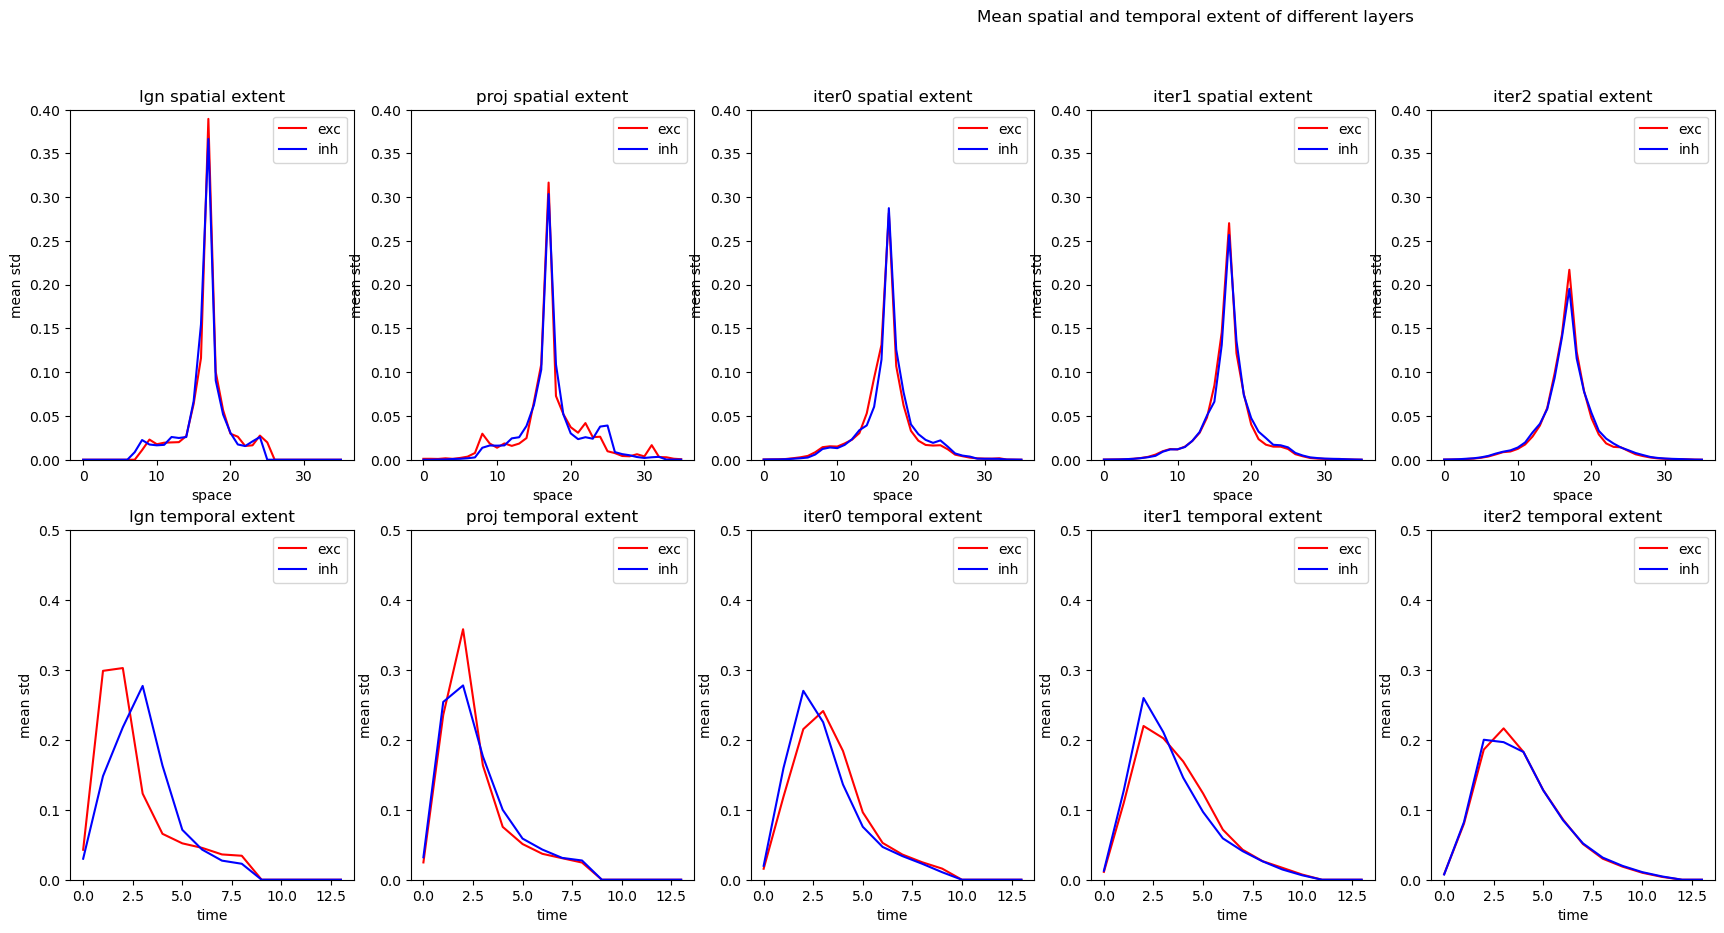

In [11]:
fig = plt.figure(figsize=(30,10))
grid = matplotlib.gridspec.GridSpec(2,7)
layer_idx = 0
for ims,name in zip([lgn, proj, iter0, iter1, iter2], ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
#for ims,name in zip([lgn, proj, iter0, iter1, iter2, iter3, iter4], ['lgn', 'proj', 'iter0', 'iter1', 'iter2', 'iter3', 'iter4']):
    ws = []
    hs = []
    ksps = []
    ax = fig.add_subplot(grid[0,layer_idx])
    for i in range(len(ims)//2):
        im = ims[i].reshape(100,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='r', label='exc')
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(100,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='b', label='inh')
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    kts = []
    ax = fig.add_subplot(grid[1,layer_idx])
    for i in range(len(ims)//2):
        im = ims[i].reshape(100,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='r', label='exc')
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(100,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='b', label='inh')
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()
    layer_idx += 1
_ = plt.suptitle('Mean spatial and temporal extent of different layers')

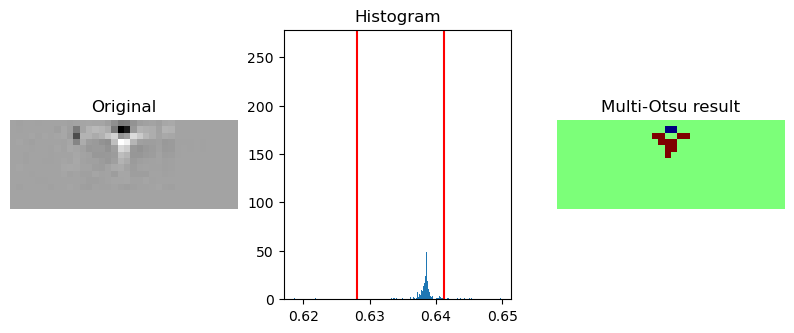

In [461]:
i = 3
im = ims[i] - np.min(ims[i]) / (np.max(ims[i]) - np.min(ims[i]))
thresholds = threshold_multiotsu(im)
regions = np.digitize(im, bins=thresholds)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

[[0.65064394 0.6510363  0.6506833  0.6502703  0.6495303  0.6490776
  0.6475044  0.6429672  0.6420425  0.64192533 0.64074385 0.64072526
  0.63879925 0.63052934 0.6298312  0.6305787  0.6307288  0.6326351
  0.63194805 0.631957   0.63131887 0.63221425 0.6337778  0.6345412
  0.6344353  0.6354016  0.63496435 0.63639444 0.646504   0.64799577
  0.6475979  0.64765596 0.648068   0.6493876  0.64966995 0.6513078 ]
 [0.65045476 0.65084785 0.6505724  0.6502372  0.64948106 0.64889467
  0.64720595 0.6425875  0.6417807  0.641725   0.6405931  0.6404287
  0.6384085  0.6300905  0.6295547  0.63022816 0.6303713  0.63219595
  0.631526   0.63153446 0.6310977  0.6320971  0.6337546  0.63441247
  0.63424337 0.6351711  0.63486695 0.6363904  0.64657587 0.6479314
  0.64762485 0.6477282  0.6481821  0.6494499  0.6497541  0.6513107 ]
 [0.6504413  0.6508398  0.6506076  0.6502601  0.6495967  0.64905345
  0.6473825  0.6426093  0.64193183 0.6418816  0.64089876 0.6408934
  0.6388727  0.63026595 0.62991655 0.6305535  0.6307

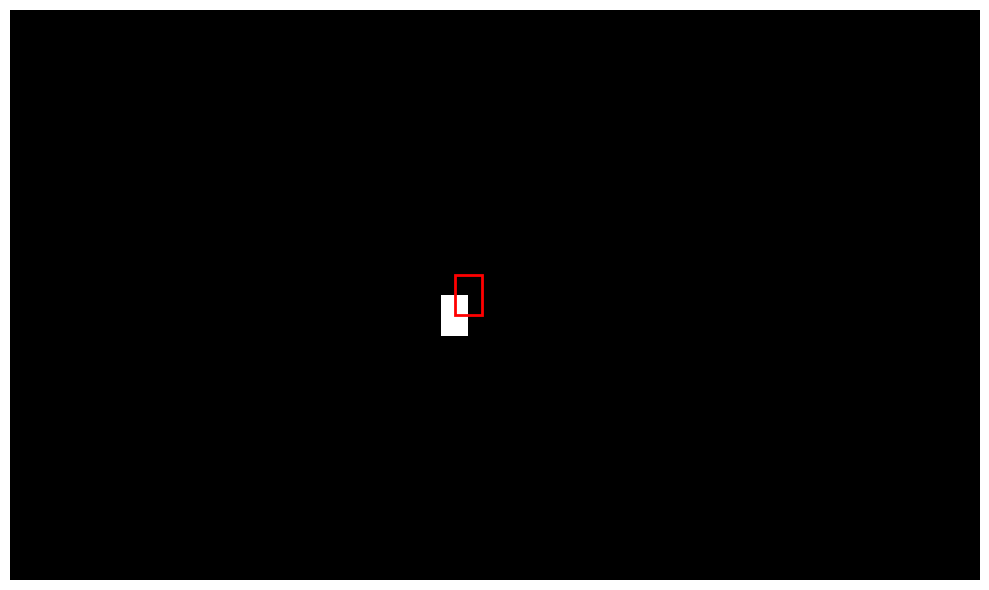

In [379]:
image = ims[1]

# normalize the image
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# apply threshold
thresh = threshold_niblack(image, window_size=15, k=0.2)
print(thresh)
print(image)
bw = image > thresh

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
print(np.unique(label_image))
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
imshow(cleared)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 1:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [293]:
from copy import deepcopy
from skimage.restoration import inpaint


# measure the spatial and temporal properties of the subunits
def bg_sub(g):
    H = 0.3  # threshold multiplier
    Q = 1.5  # threshold surface distance multipler
    WIN = 5 # scanning window height and width
    h,w = g.shape

    # create other matrices to store information
    bg = np.copy(g)       # this is the foreground removed image (background)
    mask = np.copy(g)     # this will serve as the mask for inpainting bg
    tsurf = np.copy(g)    # this will store the threshold at each point

    # compute block-based means
    Vnoise = 20
    Vsum = 0.0
    Vcnt = 0
    # first, estimate Vnoise, then remove foreground pixels
    for k in range(0, 2):
        for i in range(0, h-h%WIN, WIN):
            for j in range(0, w-w%WIN, WIN):
                m = np.mean(g[i:i+WIN, j:j+WIN])
                v = np.var(g[i:i+WIN, j:j+WIN])
                if k == 0:
                    tsurf[i,j] = H * m + Vnoise
                    if v < tsurf[i,j]:
                        Vsum += v
                        Vcnt += 1
                if k == 1:
                    tsurf[i,j] = H * m + Vnoise
                    if v > tsurf[i,j]:
                        bg[i:i+WIN, j:j+WIN] = 0
                        mask[i:i+WIN, j:j+WIN] = 255
                    else:
                        bg[i:i+WIN, j:j+WIN] = m
                        mask[i:i+WIN, j:j+WIN] = 0
    bg = inpaint.inpaint_biharmonic(bg, mask)
    d = np.mean(g - bg)
    tsurf = bg - Q*d

    return bg, mask, tsurf

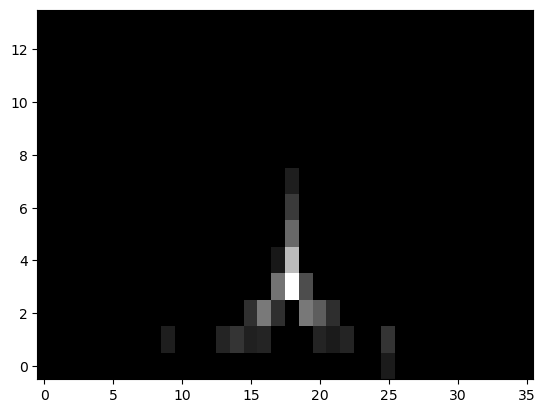

In [310]:
g = ims[0]
bg, mask, tsurf = bg_sub(g)
h,w = g.shape
threshg = deepcopy(g)
threshg[g-tsurf<0.01] = 0
imshow(threshg)

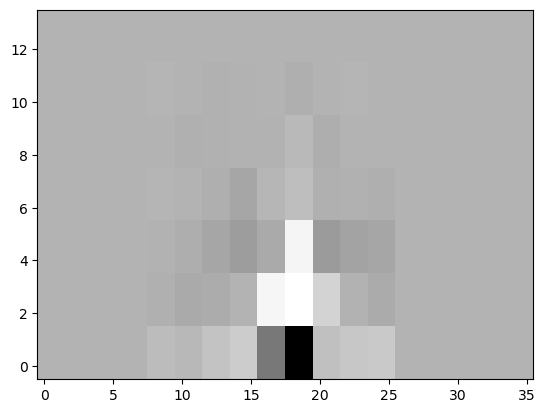

In [193]:
i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        if li == 0:
            name = 'LGN'
        elif li == 1:
            name = 'Proj'

        if li < 2:
            num_subunits = results_outputs.outputs[ni][li].shape[1]
            for subunit in range(num_subunits):
                print(name + ' subunit %d' % subunit)
                i += 1
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                name = 'Iter %d' % iter
                num_subunits = results_outputs.outputs[ni][li].shape[2]
                for subunit in range(num_subunits):
                    print(name + ' subunit %d' % subunit)
                    i += 1

LGN subunit 0
LGN subunit 1
LGN subunit 2
LGN subunit 3
Proj subunit 0
Proj subunit 1
Proj subunit 2
Proj subunit 3
Proj subunit 4
Proj subunit 5
Proj subunit 6
Proj subunit 7
Proj subunit 8
Proj subunit 9
Proj subunit 10
Proj subunit 11
Proj subunit 12
Proj subunit 13
Proj subunit 14
Proj subunit 15
Iter 0 subunit 0
Iter 0 subunit 1
Iter 0 subunit 2
Iter 0 subunit 3
Iter 0 subunit 4
Iter 0 subunit 5
Iter 0 subunit 6
Iter 0 subunit 7
Iter 0 subunit 8
Iter 0 subunit 9
Iter 0 subunit 10
Iter 0 subunit 11
Iter 0 subunit 12
Iter 0 subunit 13
Iter 0 subunit 14
Iter 0 subunit 15
Iter 1 subunit 0
Iter 1 subunit 1
Iter 1 subunit 2
Iter 1 subunit 3
Iter 1 subunit 4
Iter 1 subunit 5
Iter 1 subunit 6
Iter 1 subunit 7
Iter 1 subunit 8
Iter 1 subunit 9
Iter 1 subunit 10
Iter 1 subunit 11
Iter 1 subunit 12
Iter 1 subunit 13
Iter 1 subunit 14
Iter 1 subunit 15
Iter 2 subunit 0
Iter 2 subunit 1
Iter 2 subunit 2
Iter 2 subunit 3
Iter 2 subunit 4
Iter 2 subunit 5
Iter 2 subunit 6
Iter 2 subunit 7
Iter 2